

# Linear modeling
Course: ITCS 4156 - Introduction to Machine Learning 

Instructor: Xiang Zhang

$
\newcommand{\xv}{\mathbf{x}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\tv}{\mathbf{t}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\thetav}{\mathbf{\theta}}
 \newcommand{\xspace}{\mathcal{X}}
 \newcommand{\yspace}{\mathcal{Y}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\tm}{\mathbf{T}}
 \newcommand{\xm}{\mathbf{X}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\im}{\mathbf{I}}
$

<br/>
<font color="blue"><b>

NAME: *Reiley Meeks*

</b> </font>

# Goal 

The goal of this activity is to practice some of the remaining steps of our ML setup (training and exploring models, evaluation, and prediction) which means we get to apply our first machine learning models, ordinary least squares (OLS) and least means squares (LMS)! We'll do so by working with the Forest Fire dataset as we have already performed data exploration and preparation so that we can get to the ML algorithms quicker (we'll hopefully).

Your job is to read through the lab and fill in any code segments that are marked by `TODO` headers and comments. **It should be noted, that all the correct outputs are given below each code cell. It might be useful to duplicate all the `TODO` cells so you can try to match the correct output with your own code!** Additionally, use the `todo_check()` output to help guide you.

# Agenda
- Load data
- Test first linear assumption: Linearity 
- Recreate data preparation pipeline
- Implement Ordinary Least Squares
- Check remaining linear assumptions
- Review gradient descent
- Implement Least Means Squares
- Test the best model

## Table of Notation

Below is a table of notation you'll encounter throughout this note and the class.

| Symbol                     | Meaning                     | Symbol    | Meaning                                                          |
|----------------------------|-----------------------------|-----------|------------------------------------------------------------------|
| $\xv$ or $\vec{x}$         | feature/input vector        | $x_i$     | $i$th element of $\xv$                                           |
| $\Xm$                      | input matrix                | $x_{i,j}$ | $i$th row and $j$th column of $\Xm$                              |
| $\yv$ or $\tv$             | labels/targets              | $n$       | number of features or columns 
| $\wv$ or $\mathbf{\theta}$ | weight/parameter vector     | $m$       | number of data samples <br>(also used to refer to the slope) |samples or rows                                   |
| $f$ or $h$                 | hypothesis function <br> (i.e., a model)        | $\hat{\yv}$ <br> $f(\xv {;} \wv)$<br>$h(\xv {;} \wv)$ | predictions <br> y-hat |
| $E$              | error or sum of error (loss)  | $SSE$      | sum of squared error function                                            |
| $MSE$                      | mean squared error| $\nabla$  | gradient (prnounced nabla)                                       |
| $\partial$                 | partial derivative          | $\alpha$  | learning rate (prnounced alpha)                                  |       
| $J$ | general placeholder for the cost/objective function | $x^T$| transpose of a vector or matrix |
$b$ | bias or y-intercept term | | |

In [150]:
# Imports for this notebook
import gc
import os
from typing import List, Tuple, Callable

# Debugger
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

In [151]:
def garbage_collect(vars_):
    for v in vars_:
        if v in globals():
            del globals()[v]
    collected = gc.collect()

def todo_check(condi_err):
    failed_err = "You passed {}/{} and FAILED the following code checks:{}"
    failed = ""
    n_failed = 0
    for check, (condi, err) in enumerate(condi_err):
        if not condi:
            n_failed += 1
            failed += f"\nFailed check [{check+1}]:\n\t Tip: {err}"

    if len(failed) != 0:
        passed = len(condi_err) - n_failed
        err = failed_err.format(passed, len(condi_err), failed)
        raise AssertionError(err.format(failed))
    print("Your code PASSED the code check!")

# Problem statement summary and data loading

![](https://fee.org/media/38322/forest-fire-3782544_1280.jpg?anchor=center&mode=crop&height=656&widthratio=2.1341463414634146341463414634&rnd=132451547710000000)

### Problem statement summary

Recall that our goal here is to help prevent and make firefighting easier by identifying "high risk" areas by either predicting how much a potential area could burn when a forest fire occurs. We think we can achieve this by using supervised learning where our labels correspond to how much an area will is likely to be burned.


### Data loading

To begin, let's fetch the Forest Fire dataset. If you don't have it then download it using the following link: https://archive.ics.uci.edu/ml/datasets/Forest+Fires. When you arrive at the UCI webite click the "Data Folder" button near the top right to download the dataset. Once clicked, download the following file: `forestfires.csv`.

Be sure to move the `forestfires.csv` file to the **SAME** directory/folder that this Jupyter Notebook is in (i.e., the current path of the notebook). We need to do this so that when we go to load the data we can easily path to the files! Run the below code to check which will print your notebook's current path and which directory the notebook is in!

In [152]:
print(f"The current path for your notebook is:\n {os.getcwd()}\n")
print(f"Your notebook is currently in the following directory:\n {os.path.basename(os.getcwd())}")

The current path for your notebook is:
 /Users/ReileyMeeks/IntroML/LabLinearRegression

Your notebook is currently in the following directory:
 LabLinearRegression


#### TODO 1
Let's load the `forestfires.csv` by using Pandas `read_csv()` function.

1. Load Forest Fires dataset using the Pandas function `read_csv()` ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)). Store the output into the `forestfire_df` variable.
    1. Hint: We wrote a custom exception to alert you if you didn't move your notebook to the correct location. So if you are getting an error take a second to read what it says.

In [153]:
# This line checks to make sure the forestfire.csv is in the 
# same directory as this notebook.
if not os.path.exists("forestfires.csv"):
    raise Exception(f"The forestfires.csv is not detected in your local path! " \
                    f"You need to move the 'forestfires.csv' file to the same " \
                    f"location/directory as this notebook which is {os.getcwd()}")   
# TODO 1.1
forestfire_df = pd.read_csv("forestfires.csv")
display(forestfire_df)

todo_check([
    (np.all(forestfire_df.iloc[0].values == np.array([7, 5, 'mar', 'fri', 86.2, 26.2, 94.3, 5.1, 8.2, 51, 6.7, 0.0, 0.0],
      dtype=object)), 'The 1st row does not match! Make sure you loaded the right dataset!')
])

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


Your code PASSED the code check!


# Checking the first linear assumption: Linearity 
With our data loaded, let's check our first linear assumption to see if a linear model will be a good choice for modeling our data. Recall that the first assumption we can check is if **our features share some form of linear relationship with our labels/targets** (in this case 'area'). 
We'll check the other linear assumptions after training a model to confirm whether they are true or not!

Let's recreate the multi-scatter plots from the data visualization lab which had us plotting the log scaled 'area' against our input features.

#### TODO 2
Complete the TODO by taking the log of our 'area' targets, extracting our input features, and then creating a multi-scatter plot which plots 'area' against all our features.
1. Use the NumPy's handy `np.log1p()` function ([docs](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html))to take the log of our 'area' feature. Recall that we usually need to add 1 to our 'area' feature as we can't take the $log(0)$. Luckily the `log1p()` function does this for us automatically. Store the output into `log_area_values`.
2. Extract all our input features **EXCEPT** for the column 'area' which will act as our target. Store the output into `features`.
    1. Hint: When you want to extract the majority of your features except a few specifically, try using the Pandas DataFrame `drop()` method to drop the features you don't want. This can be easier than specifying all the features individually
3. Complete the for loop which loops over each feature in `features` and plots a sub-plot where the current feature given by the `column_name` variable is plotted on the x-axis and the target 'area', stored in the `log_area_values` variable, is plotted on the y-axis.
    1. Hint: Using `plt.plot` plot the current feature specified by `column_name` on the x-axis and our targets 'area', specified by `log_area_values`, on the y-axis.
    1. Note: No TODO check here. Compare the output with the below image.
    
<img src="https://live.staticflickr.com/65535/51876122139_3569bbc7fd_o.png" width="400" height="300" alt="linear_models-2-3">

In [154]:
# TODO 2.1
log_area_values = np.log1p(forestfire_df['area'])
display(log_area_values)

todo_check([
    (np.all(np.isclose(log_area_values[512:].values, np.array([2.00687085, 4.01259206, 2.49815188, 0.        , 0.        ]),rtol=.01)), "log_area_values values were incorrect! Make sure you applied log1p() or added 1 and took the log!"),
])

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
512    2.006871
513    4.012592
514    2.498152
515    0.000000
516    0.000000
Name: area, Length: 517, dtype: float64

Your code PASSED the code check!


In [155]:
# TODO 2.2
features = forestfire_df.drop(columns=['area'])

todo_check([
    (features.shape == (517, 12), 'features shape did not match the shape (517, 12)'),
    (np.all(features.iloc[5, 4:].values == np.array([92.3, 85.3, 488.0, 14.7, 22.2, 29, 5.4, 0.0])), "features values are incorrect!")
])

Your code PASSED the code check!


/var/folders/28/r4m7dmwj7xd7sr0tntk2_z600000gn/T/ipykernel_54454/2359457090.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, idx+1)


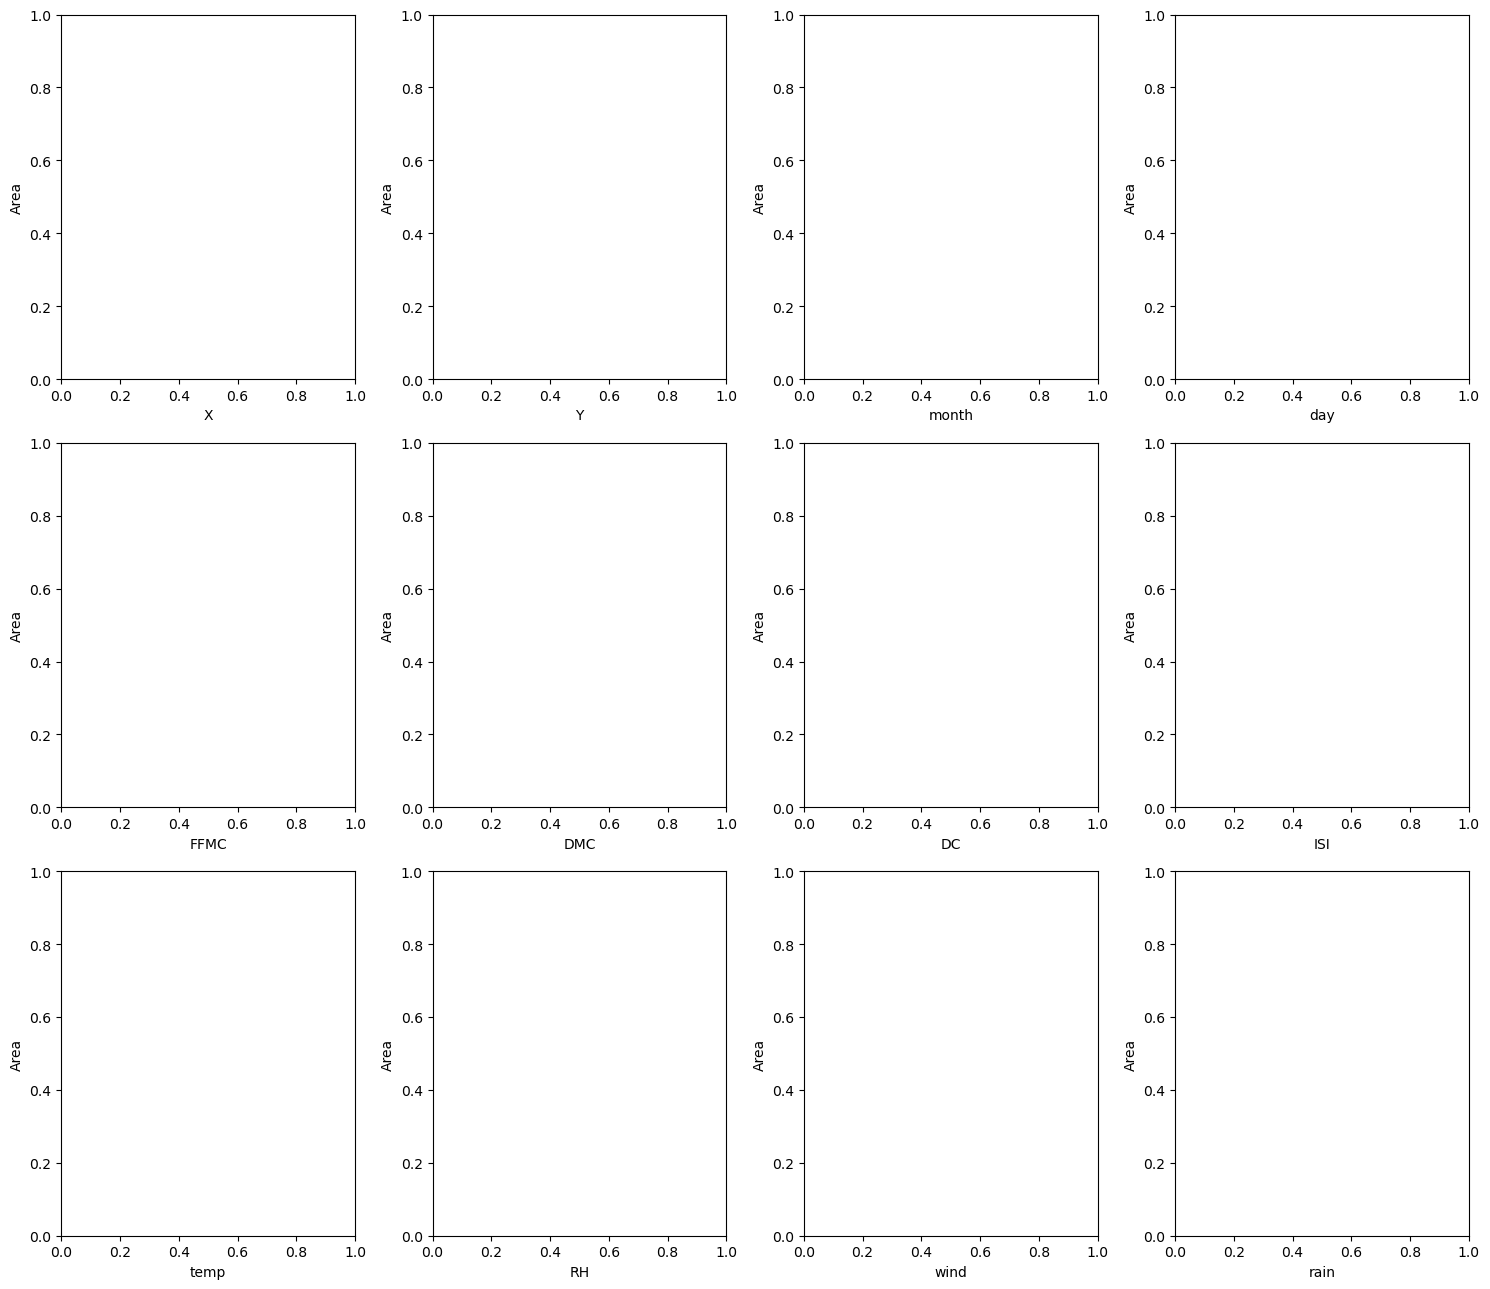

In [156]:
fig, _ = plt.subplots(figsize=(15, 13))

# column_name holds the current column name
# idx holds the current column index
# You can use either to index features to get the current feature
for idx, column_name in enumerate(features.columns.values):
    # Sets sub-plot index
    plt.subplot(3, 4, idx+1)
    
    # TODO 2.3
    
    
    plt.ylabel('Area')
    plt.xlabel(column_name)

    
fig.tight_layout()
plt.show()

Take a second to see if you notice any linear patterns or any patters at all?

Further recall the correlation matrix from last week where we saw that there were no strong correlations between any **single** variable and our target 'area'. 

In [157]:
corr_matrix = forestfire_df.corr()
corr_matrix['area']

/var/folders/28/r4m7dmwj7xd7sr0tntk2_z600000gn/T/ipykernel_54454/1975786083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = forestfire_df.corr()


X       0.063385
Y       0.044873
FFMC    0.040122
DMC     0.072994
DC      0.049383
ISI     0.008258
temp    0.097844
RH     -0.075519
wind    0.012317
rain   -0.007366
area    1.000000
Name: area, dtype: float64

The correlation matrix and our visualization are a good indication that **no single feature in our data really seems to have a strong or any linear trend with our target 'area'** This means that performing single linear regression (linear regression based on a single feature) is probably a bad idea.

However, this isn't the end of the world. We don't know how the regression algorithm will act when considering **all** our features together - though it's not looking great. Moving forward with a linear model might still be worth a shot if we use all our features or a selection. Further note, even if the linear model performs poorly it sets a good baseline we can then use to compare to more complex models.

# Data Preparation Pipeline

Now it's time to recreate our data preparation pipelines from last week. We are going to make some slight changes such that we have less conflicting code, meaning our code is more encapsulated. With this in mind, we have to spend another decent amount of time on this section.

Let's import all the sklean pipeline stuff we'll be needing.

In [158]:
import sklearn
# Check to make sure you have the right version of sklearn
assert sklearn.__version__  >= '1.0.1', f'sklearn version is only {sklearn.__version__} and needs to be >= 1.0.1'

In [159]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Defining our own ColumnTransformer

In the previous lab (data visualization) we used the `ColumnTrasformer` class from Sklearn in order to apply our data cleaning and transformations methods to certain columns in our. While we'll still be using the `ColumnTrasformer`, we are going to wrap it's functionality in our own class (otherwise known as creating a "wrapper"). 

But why do this? Recall that the output of a `Columntransformer` is always a NumPy array. We want our output to be a Pandas DataFrame for greater flexibility since we can easily convert a DataFrame to a NumPy array. To achieve this we define our own wrapper called `DataFrameColumnTransformer`. This class simply makes sure the output of our `Columntransformer` is a DataFrame.

To achieve this we will have to slightly edit each one of our data cleaning and transformations classes we defined last week (`OneHotEncoding`, `LogTransformer` and `Standardization`) to include the a class variable called `self.feature_names` which will track the feature names for the data passed to the class (these will be used to construct the column names for a DataFrame). Additionally, we will define a `get_feature_names_out()` method which allows us to easily return these feature names. 

Once our data has passed through the `Columntransformer` we can then use the `Columntransformer.get_feature_names_out()` method which will grab the feature names from each data cleaning and transformation class by calling their corresponding `get_feature_names_out()` method. With the feature names in hand, we can easily turn our NumPy array into a DataFrame!


Initializing our `DataFrameColumnTransformer` class will work just like `Columntransformer`. See example below.

```Python
df_col_trans = DataFrameColumnTransformer([
    ('name', Class(), ['feature_name_1', 'feature_name_2']),
    ('another_name', AnotherClass(), ['feature_name_3'])
])
```

Take time to look through the code for the below class.

In [160]:
class DataFrameColumnTransformer(TransformerMixin):
    def __init__(self, stages: List[Tuple]):
        self.col_trans = ColumnTransformer(stages)
    
    def fit(self, X: pd.DataFrame):
        """ Runs our ColumnTransformer.fit() method """
        self.col_trans.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """ Runs our ColumnTransformer.transform() method """
        output_arr = self.col_trans.transform(X)
        
        return self.to_dataframe(output_arr)
    
    def to_dataframe(self, arr: np.ndarray) -> pd.DataFrame:
        """Converts our output of ColumnTransformer into a DataFrame"""
        feature_names = self.col_trans.get_feature_names_out()
        
        # Remove the "__" that ColumnTransformer adds to our feature names
        # when we call self.col_trans.get_feature_names_out()
        for i, name in enumerate(feature_names):
            if '__' in name:
                feature_names[i] = name.split('__', 1)[-1]
        
        # Creates a Pandas Dataframe
        df = pd.DataFrame(arr, columns=feature_names)
        
        return df

## Pre-split

Let's quickly define our pre-split data cleaning and transformation class from last week: `OneHotEncoding` and `LogTransformer`. We won't make you program them again but do take note of the changes we have implemented. If you don't recall how they work review the previous lab (data visualization).


### Redefining OneHotEncoding and LogTransformer


- Changes
    - Added `self.feature_names` to both classes
    - Added `get_feature_names_out()` to both classes
    - Added more Python hinting
        - Recall `X: pd.DataFrame` the `: pd.DataFrame` hints at what type the `X` argument should be receiving. This is just a like a comment through, strict typing is NEVER enforced by Python.
        - The ` -> pd.DataFrame` hints at what the return type should be.

In [161]:
class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None):
        
        # We don't need to set/learn any variables so
        # we just need to return a reference to the object with 'self'
        # If we dont return self the Pipeline class will throw errors
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        
        one_hot = pd.get_dummies(X)
        self.feature_names = one_hot.columns
        
        return one_hot
    
    def get_feature_names_out(self, names=None)-> List[str]:
        return list(self.feature_names)

In [162]:
class LogTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None):
        
        # We don't need to set/learn any variables so
        # we just need to return a reference to the object with 'self'
        # If we dont return self the Pipeline class will throw errors
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        self.feature_names = X.columns
        
        return np.log1p(X)
    
    def get_feature_names_out(self, names=None) -> List[str]:
        return list(self.feature_names)

### Creating a cleaning pipeline

Now it's time to create out before splitting pipeline from last week. This time we are going to wrap all the code for creating and running the pipeline in a function so that we can easily recall these steps at any time!

#### TODO 3
Complete the TODO by finishing the `before_pipeline()` function.

1. Define the 3 pre-split stages that our `DataFrameColumnTransformer` class will take in. **Recall this must be a <u>list of tuples </u>.** Store the output in `stages`
    1. The first tuple should be our pass through stage which simply passes the columns we don't use so that they are added to the output. Define the tuple as follows:
        1. Element 1 should be set to the string 'pass'. Recall you can really set this to any string you'd like, it is just a name for the current stage.
        2. Element 2 should be set to the string 'passthrough'. Recall this is how we indicate we want `ColumnTransformer` to simply pass our columns to the output.
        3. Element 3: should be set to `passthrough_cols` which contains the names of the columns we want to pass through.
    2. Define the one-hot encoding stage by defining a tuple as follows:
        1. Element 1 should be set to the string 'one_hot'.
        2. Element 2 should be set an **instance** of our `OneHotEncoding` class
        3. Element 3 should be set to a **list** containing the names of our categorical features 'month' and 'day'.
    3. Define the log transformation encoding stage by defining a tuple as follows:
        1. Element 1 should be set to the string 'log'.
        2. Element 2 should be set an **instance** of our `LogTransformer` class
        3. Element 3 should be set to a **list** containing the name of our label/target 'area'.
2. Create an instance of our `DataFrameColumnTransformer` and pass `stages`, the data cleaning and transformation stages we just defined above. Store the output into the variable `before_pipe`.
3. Call the `fit_transform()` method for our `before_pipe` instance to fit and then transform our Forest Fire data by passing the `forestfire_df` variable. Store the output into `cleaner_df`.

These are very similar with the last lab (data preparation), please check the codes in the previous lab if you are confused by this TODO.

In [163]:
def before_pipeline(forestfire_df):
    passthrough_cols = forestfire_df.drop(['month', 'day', 'area'], axis=1).columns 

    # TODO 3.1
    stages = [('pass', 'passthrough', passthrough_cols), 
              (['one_hot', OneHotEncoding(), ['month', 'day']]), 
              ('log', LogTransformer(), ['area'])]

    # TODO 3.2
    before_pipe = DataFrameColumnTransformer(stages)
    
    # TODO 3.3
    cleaner_df = before_pipe.fit_transform(forestfire_df)
    
    return cleaner_df

Once you think you have completed the `before_pipeline()` function run the below code to test the function. Observe the displayed DataFrame to see if the transformations were correctly applied. 

In [164]:
cleaner_df = before_pipeline(forestfire_df)

print(f"forestfire_arr shape: {cleaner_df.shape}")
print(f"forestfire_arr type: {type(cleaner_df)}")
display(cleaner_df)

todo_check([
    (cleaner_df.shape == (517, 30),'cleaner_df shape does not match (517, 30)'),
    (np.isclose(cleaner_df.describe().loc['mean', 'area'],  1.11, rtol=.01),'cleaner_df area has incorrect values. Make sure LogTransformer was applied to the area target.'),
    (np.all(pd.Series(['month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov','month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun','day_thu', 'day_tue', 'day_wed']).isin(cleaner_df.columns)), 'cleraner_df got incorrect values for the month and day one-hot conversion. Make sure OneHotEncoding was applied to the month and day columns.')
])

garbage_collect(['cleaner_df']) 

forestfire_arr shape: (517, 30)
forestfire_arr type: <class 'pandas.core.frame.DataFrame'>


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,area
0,7.0,5.0,86.2,26.2,94.3,5.1,8.2,51.0,6.7,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,7.0,4.0,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
2,7.0,4.0,90.6,43.7,686.9,6.7,14.6,33.0,1.3,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
3,8.0,6.0,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,8.0,6.0,89.3,51.3,102.2,9.6,11.4,99.0,1.8,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4.0,3.0,81.6,56.7,665.6,1.9,27.8,32.0,2.7,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.006871
513,2.0,4.0,81.6,56.7,665.6,1.9,21.9,71.0,5.8,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.012592
514,7.0,4.0,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.498152
515,1.0,4.0,94.4,146.0,614.7,11.3,25.6,42.0,4.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


Your code PASSED the code check!


## Splitting data 

Now on to splitting! Let's quickly create some function to split our data into input features and labels. Further, let's also create a function to split out data into a training, validation, and test set!

### Feature and Label Splitting

#### TODO 4
Complete the TODO by finishing the `feature_label_split()` function

1. Extract all the features from our `cleaner_df` **EXCEPT** for our target 'area'. Store the output into the variable `X`.
    1. Hint: Use the `drop()` method to drop only 'area'. `drop` will also return a copy of our data without 'area'!
2. Extract a <u>**copy**</u> of our target 'area'. Store the output into the variable `y`.
    1. Hint: Try using normal indexing with `.iloc`, `loc` or `[ ]` and then call the `copy()` method on the extracted 'area' Series to make a copy!
    1. As a note, it is best practice to make copies of the data if it isn't too large. This will prevent any changes we make from affecting the `cleaner_df`. Try using the `.copy()` method on your extracted 'area' data.

In [165]:
def feature_label_split(cleaner_df):
    # TODO 4.1
    X = cleaner_df.drop('area', axis=1)
    # TODO 4.2
    y = cleaner_df['area'].copy()
    
    return X, y

Run the below code to check if you correctly implemented the `feature_label_split()` function.

In [166]:
# Apply pre-split cleaning
cleaner_df = before_pipeline(forestfire_df)
# Apply feature and label splitting
X, y = feature_label_split(cleaner_df)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

todo_check([
    (X.shape == (517,29), 'X shape does not match (517, 29)'),
    (y.shape == (517,), 'y shape does not match (517,)'),
    (not id(y) == id(cleaner_df['area']), "Memory address of y matched cleaner_df['area']. Make sure to call the .copy() method after indexing 'area' column"),
    (np.isclose(y[512],2.006871), 'y has the wrong values. Make y corresponds to the area column.') 
])

garbage_collect(['X', 'y', 'cleaner_df'])

X shape: (517, 29)
y shape: (517,)
Your code PASSED the code check!


### Train, validation and test splits

#### TODO 5
Complete the TODO by finishing the `train_valid_test_split()` function.

1. It's time to start practicing importing. Import the `train_test_split` function from `sklearn.model_selection`. See [this tutorial](https://www.geeksforgeeks.org/import-module-python/) for more help.
    1. Hint: use the import structure: `from <module name> import <function or class name>`.
2. Use Sklearn's `train_test_split()` function ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) to get a train and test split. Store the output into `X_trn`, `X_tst`, `y_trn`, and `y_tst`.
    1. Pass the required arguments `X` and `y`. 
    2. Further specify we want to use 20% or .2 of the training data by setting the `test_size` keyword argument. 
    3. Lastly, pass the keyword argument `random_state=42` to set the random seed so we get the same split every time we run this code. 
2. Use the `train_test_split()` function create a new train split and a validation split. Store the output into `X_trn`, `X_vld`, `y_trn`, and `y_vld`.
    1. Pass the required arguments `X_trn` and `y_trn`. 
    2. Further specify we want to use 20% or .2  of the training data by setting the `test_size` keyword argument. 
    3. Lastly, pass the keyword argument `random_state=42` to set the random seed so we get the same split every time we run this code. 

In [167]:
# TODO 5.1
from sklearn.model_selection import train_test_split

todo_check([
    ('train_test_split' in globals(), 'train_test_split does not appear to have been imported!')
])

Your code PASSED the code check!


In [168]:
def train_valid_test_split(X, y):
    # TODO 5.2
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.20, random_state=42)
    # TODO 5.3
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.20, random_state=42)
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

Run the below code to check your implementation of `train_valid_test_split()`.

In [169]:
# Apply pre-split cleaning
cleaner_df = before_pipeline(forestfire_df)
# Apply feature and label splitting
X, y = feature_label_split(cleaner_df)
# Apply train, validation and test set splitting
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)

print(f"X_trn shape: {X_trn.shape}")
print(f"y_trn shape: {y_trn.shape}")
print(f"X_vld shape: {X_vld.shape}")
print(f"y_vld shape: {y_vld.shape}")
print(f"X_tst shape: {X_tst.shape}")
print(f"y_tst shape: {y_tst.shape}")

todo_check([
    (X_trn.shape == (330,29), 'X_trn shape is not (330, 29)'),
    (y_trn.shape == (330,),'y_trn shape is not (330,)'),
    (X_vld.shape == (83,29),'X_vld shape is not (83, 29)'),
    (y_vld.shape == (83,),'y_vld shape is not (83,)'),
    (X_tst.shape == (104,29),'X_tst shape is not (104, 29)'),
    (y_tst.shape == (104,),'y_tst shape is not (104,)'),
    (np.all(np.equal(X_trn.iloc[:5, 0].values, np.array([5.0, 3.0, 7.0, 3.0, 8.0]))), 'X_trn does not have the correct values!'),
    (np.all(np.equal(X_tst.iloc[:5, 0].values, np.array([6.0, 7.0, 8.0, 5.0, 2.0]))), 'X_tst does not have the correct values!'),
    (np.all(np.isclose(y_trn[:3].values, np.array([1.2725656, 0.       , 0.       ]), rtol=.01)), 'y_trn does not have the correct values!'),
    (np.all(np.isclose(y_tst[:3].values, np.array([0.        , 0.        , 0.80200159]), rtol=.01)), 'y_tst does not have the correct values!'),
])

garbage_collect(['X', 'y', 'cleaner_df'])

X_trn shape: (330, 29)
y_trn shape: (330,)
X_vld shape: (83, 29)
y_vld shape: (83,)
X_tst shape: (104, 29)
y_tst shape: (104,)
Your code PASSED the code check!


/var/folders/28/r4m7dmwj7xd7sr0tntk2_z600000gn/T/ipykernel_54454/3162920900.py:24: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  (np.all(np.isclose(y_trn[:3].values, np.array([1.2725656, 0.       , 0.       ]), rtol=.01)), 'y_trn does not have the correct values!'),
/var/folders/28/r4m7dmwj7xd7sr0tntk2_z600000gn/T/ipykernel_54454/3162920900.py:25: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  (np.all(np.isclose(y_tst[:3].values, np.array([0.        , 0.        , 0.80200159]), rto

Let's quickly check how balanced our data is. What do we mean by "balance"? Well, what we are interested in seeing is **whether our train, validation, and test sets have roughly an equal number labels/targets**. 

In regards to regression this means we want to see if the number of samples with 'area' greater than 0 is roughly the same as the 'area' equal to zero. If this is not the case then our model might be biased towards predicting values near zero or above zero! We'll look at another closely related issue that also concerns balancing later on in this lab.

Below we do this check and we can see that our labels seem relatively evenly split! Luckily, the `train_test_split()` function automatically splits our data in this "even" fashion so this check is kind of redundant. If you were manually splitting data than this would be an important concept to keep in mind.

Here we check if our train data has roughly the same number of data samples with area greater than zero and equal to zero.

In [170]:
y_trn[y_trn > 0].shape

(177,)

In [171]:
y_trn[y_trn == 0].shape

(153,)

Here we check if our validation data has roughly the same number of data samples with area greater than zero and equal to zero.

In [172]:
y_vld[y_vld > 0].shape

(40,)

In [173]:
y_vld[y_vld == 0].shape

(43,)

Here we check if our test data has roughly the same number of data samples with area greater than zero and equal to zero.

In [174]:
y_tst[y_tst > 0].shape

(53,)

In [175]:
y_tst[y_tst == 0].shape

(51,)

In [176]:
# Remove variables from memory to prevent errors/confusion later on in the lab
del X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

## Post-split

Finally, let' move on to our post-split data cleaning and transformation. Recall last week we only had a single post-split class `Standardization`. This week we are going to add a class called `AddBias` which will add the bias term to our train, validation, and test data!

### Adding the bias term to our data
Typically linear models embed a bias term into the features by adding a column of 1's - these are actually called affine models. The bias column allows for the least squares algorithm, and others, to create a solution that is not restricted to passing through the origin! Instead, the bias term allows the solution to shift the line of best fit up and down the y-axis.

Think of a *linear function* $y = mx$ or more concretely an equation like $y = 5x$. This linear function is restricted to passing through the origin thus it can be harder to fit data. Now consider an *affine function* $y = mx + b$ or more concretely an equation like $y = 5x + 1$. This new affine function allows us to adjust the point at which our line of best fit intersects the y-axis (we are no longer confined to the origin). Essentially, adding the bias term is allowing for more flexibility in our models. See the below image for a visual reference!

![](https://qph.fs.quoracdn.net/main-qimg-c0bb76e8e57e9a33170c45265eadb213)

#### TODO 6
Complete the TODO by finishing the `transform()` method for the `AddBias` class.

1. Copy the `X` data by calling the `copy()` method on `X`. This will prevent any changes we make to the DataFrame that is passed to `X` from being reflected in the original DataFrame. Store the output into `X`.
2. Insert/add a column of ones (bias variables) to our data `X`. Make sure the bias column is the **1st column (index 0)**. Use the DataFrame `insert()` method to add the bias as directed below ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html)). No need to store the output as `insert()` edits our `X` object inplace.
    1. The first argument of `insert` corresponds to the location we want to insert. Recall we want our bias column to be the **1st column** in `X`.
    2.The second argument of `insert` corresponds to the name we want to call our column. Call it 'bias'.
    3.The third argument of `insert` corresponds the value of the column. If you pass an scalar it fills the entire column with said scalar value. Pass 1, as we typically set the bias feature equal to 1.

In [177]:
class AddBias(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None) -> pd.DataFrame:
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        
        # TODO 6.1
        X = X.copy()
        # TODO 6.2
        X.insert(0, "bias", 1)
        
        self.feature_names = X.columns
        return X
    
    def get_feature_names_out(self, names=None) -> List[str]:
        return list(self.feature_names)

Run the below code to check your `AddBias` implementation.

In [178]:
# Apply pre-split cleaning
cleaner_df = before_pipeline(forestfire_df)
# Apply feature and label splitting
X, y = feature_label_split(cleaner_df)
# Apply train, validation and test set splitting
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)

add_bias =  AddBias()
X1_trn = add_bias.fit_transform(X_trn)
# Print X1_trn dataframe
display(X1_trn)

todo_check([
    (X1_trn.columns[0], 'bias is missing from the column names!'),
    (np.all(X1_trn['bias'] == 1), 'bias column is not equal to all 1s'),
])

garbage_collect([ 'X_trn', 'y_trn', 'X_vld', 'y_vld', 'X_tst', 'y_tst', 'X', 'y', 'cleaner_df', 'add_bias', 'X1_trn'])

,bias,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
170,1,5.0,4.0,92.9,133.3,699.6,9.2,21.9,35.0,1.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
268,1,3.0,4.0,92.1,152.6,658.2,14.3,21.0,32.0,3.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24,1,7.0,4.0,93.5,139.4,594.2,20.3,23.7,32.0,5.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
152,1,3.0,4.0,90.1,51.2,424.1,6.2,24.6,43.0,1.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,8.0,6.0,89.3,51.3,102.2,9.6,11.4,99.0,1.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1,8.0,8.0,91.7,191.4,635.9,7.8,26.2,36.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
109,1,4.0,5.0,88.6,91.8,709.9,7.1,17.4,56.0,5.4,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
61,1,2.0,2.0,89.3,51.3,102.2,9.6,5.5,59.0,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13,1,6.0,5.0,90.9,126.5,686.5,7.0,21.3,42.0,2.2,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Your code PASSED the code check!


### Redefining Standardization
- Changes
    - Added `self.feature_names`
    - Added `get_feature_names_out()` 
    - Added more Python hinting   

In [179]:
class Standardization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None) -> pd.DataFrame:
        
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
    
    def transform(self, 
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        self.feature_names = X.columns
        return (X  - self.mean) / self.std

    def get_feature_names_out(self, name=None) -> pd.Series:
        return self.feature_names

### Creating a cleaning pipeline

Now it's time to create out after splitting pipeline. This time we are going to wrap all the code for creating and running the pipeline in a function so that we can easily recall these steps at any time!

#### TODO 7
Complete the TODO by finishing the `after_pipeline()` function.

Take note that this function is a little different from our `before_pipeline()` function. Now, sense we want to apply `Standardization` and `AddBias` to all our data, we can use the `Pipeline` class ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)). Recall, the  Sklearn `Pipeline` class works just like `ColumnTransformer` but applies the data preparation class to ALL columns.

1. Define the 2 post-split data preparation stages that the `Pipeline` class will take in. **Recall this must be a <u>list of tuples </u>.** Store the output in `stages`.
    1. Define the standardization data prep stage by defining a tuple as follows:
        1. Element 1 should be set to the string 'scaler'.
        2. Element 2 should be set an **instance** of our `Standardization` class
    3. Define the add bias stage to add the bias column to our data by defining a tuple as follows:
        1. Element 1 should be set to the string 'bias'.
        2. Element 2 should be set an **instance** of our `AddBias` class
        
2. Create an instance of our `Pipeline` and pass `stages`, the data cleaning and transformation stages we just defined above. Store the output into the variable `after_pipe`.

1. Call the `fit_transform()` method of `after_pipe` instance and pass our training data `X_trn`.  Store the output into `X_trn_clean`.
    1. Note: recall that this calls both `fit()` which extracts any needed information from the passed data and then `transform()` uses said extracted information to automatically apply the data cleaning and transformation methods to the data.
    
2. Call the `transform()` method of `after_pipe` to ONLY apply the transformations to our validation data `X_vld`. Store the output into `X_vld_clean`.
    1. Note: Remember, we never want to apply the `fit()` method to our "unseen" data such as the validation and test set splits.
    
3. Call the `transform()` method method of `after_pipe` to ONLY apply the transformations to our test data `X_tst`. Store the output into `X_tst_clean`.

*Note: although the instruction says using `Pipeline` class, you can use other ways such as `ColumnTransformer` to do the same thing. You have full freedom in coding as long as the results are correct.*

In [180]:
def after_pipeline(X_trn, X_vld, X_tst):
    # TODO 7.1
    stages = [('scaler', Standardization()), 
              ('bias', AddBias())]
    
    # TODO 7.2
    after_pipe = Pipeline(stages) 
    
    # TODO 7.3
    X_trn_clean = after_pipe.fit_transform(X_trn)
    # TODO 7.4
    X_vld_clean = after_pipe.transform(X_vld)
    # TODO 7.5
    X_tst_clean = after_pipe.transform(X_tst)
    
    return X_trn_clean, X_vld_clean, X_tst_clean
    

Run the below code to check your `after_pipeline` implementation.

In [181]:
# Apply pre-split cleaning
cleaner_df = before_pipeline(forestfire_df)
# Apply feature and label splitting
X, y = feature_label_split(cleaner_df)
# Apply train, validation and test set splitting
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)
# Apply post-split cleaning
X_trn, X_vld, X_tst = after_pipeline(X_trn, X_vld, X_tst)

print(f"X_trn shape: {X_trn.shape}")
print(f"X_trn type: {type(X_trn)}")
print(f"X_vld shape: {X_vld.shape}")
print(f"X_vld type: {type(X_vld)}")
print(f"X_tst shape: {X_tst.shape}")
print(f"X_tst type: {type(X_tst)}")

display(X_trn)

todo_check([
    (np.all(np.isclose(X_trn.iloc[:3, 3], [.395645, .262909, .495198], rtol=.01)), 'X_trn has the wrong values!'),
    (np.all(np.isclose(X_vld.iloc[:3, 3], [-3.702595, .113580, .528382], rtol=.01)), 'X_vld has the wrong values!'),
    (np.all(np.isclose(X_tst.iloc[:3, 3], [-0.898536, .926591, .262909], rtol=.01)), 'X_tst has the wrong values!'),
])

garbage_collect([ 'X_trn', 'y_trn', 'X_vld', 'y_vld', 'X_tst', 'y_tst', 'X', 'y', 'cleaner_df'])

X_trn shape: (330, 30)
X_trn type: <class 'pandas.core.frame.DataFrame'>
X_vld shape: (83, 30)
X_vld type: <class 'pandas.core.frame.DataFrame'>
X_tst shape: (104, 30)
X_tst type: <class 'pandas.core.frame.DataFrame'>


,bias,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
170,1,0.165357,-0.246620,0.395645,0.324517,0.611867,0.111110,0.543906,-0.592774,-1.279994,...,-0.055132,-0.176777,1.385768,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,-0.349927,3.000000
268,1,-0.707728,-0.246620,0.262909,0.616453,0.447616,1.422454,0.386214,-0.773899,-0.534316,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,2.857738,-0.333333
24,1,1.038442,-0.246620,0.495198,0.416787,0.193700,2.965213,0.859291,-0.773899,1.014401,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,2.423840,-0.5,-0.366088,-0.349927,-0.333333
152,1,-0.707728,-0.246620,-0.068932,-0.917345,-0.481158,-0.660269,1.016983,-0.109773,-1.279994,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,2.423840,-0.5,-0.366088,-0.349927,-0.333333
4,1,1.474985,1.466741,-0.201669,-0.915833,-1.758272,0.213960,-1.295838,3.271234,-1.279994,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,2.0,-0.366088,-0.349927,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1,1.474985,3.180102,0.196541,1.203350,0.359142,-0.248867,1.297325,-0.532399,0.268722,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,-0.349927,3.000000
109,1,-0.271186,0.610060,-0.317813,-0.303221,0.652731,-0.428856,-0.244556,0.675104,0.784961,...,-0.055132,-0.176777,1.385768,-0.456937,2.338929,-0.412568,-0.5,-0.366088,-0.349927,-0.333333
61,1,-1.144271,-1.959981,-0.201669,-0.915833,-1.758272,0.213960,-2.329600,0.856229,1.301200,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,2.0,-0.366088,-0.349927,-0.333333
13,1,0.601900,0.610060,0.063804,0.221659,0.559894,-0.454568,0.438778,-0.170148,-1.050555,...,-0.055132,-0.176777,1.385768,-0.456937,2.338929,-0.412568,-0.5,-0.366088,-0.349927,-0.333333


Your code PASSED the code check!


##  Putting it all together

In order to make our lives easier we create a function called `data_prep()` which will run all the pre-split, splitting, and post-split data cleaning and transformations for us. Further, it will return our train, validation, and test data for us and apply any other small changes we need to make to the data. Thus, whenever we go to implement a new  algorithm we can call `data_prep()` to give us our data!

Take a second to go through the below code and make sure it makes sense. For the most part, we are just combining all the functions we defined above.

In [182]:
def data_prep(forestfire_df: pd.DataFrame, 
              return_array: bool = False,
              drop_features: List = None) -> Tuple[pd.DataFrame]:
    """ Splits data and runs before and after split data cleaning and transformations
    
        Args:
            forestfire_df: A Pandas DataFrame containing the Forest Fire data
            
            return_array: A boolean which when True will return all data as NumPy
                arrays instead of Pandas DataFrames.
                
            drop_features: List of feature names to drop
    """
    # Apply pre-split cleaning
    cleaner_df = before_pipeline(forestfire_df)
    # Apply feature and label splitting
    X, y = feature_label_split(cleaner_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)
    # Apply post-split cleaning
    X_trn, X_vld, X_tst = after_pipeline(X_trn, X_vld, X_tst)

    # Resets the Pandas index for the Dataframe and series
    # This will prevent any headaches when combining or indexing
    # our train, validation, and test data in the future.
    X_trn.reset_index(inplace=True, drop=True)
    y_trn.reset_index(inplace=True, drop=True)
    X_vld.reset_index(inplace=True, drop=True)
    y_vld.reset_index(inplace=True, drop=True)
    X_tst.reset_index(inplace=True, drop=True)
    y_tst.reset_index(inplace=True, drop=True)
    
    # Drop any features we don't want
    if drop_features is not None:
        X_trn, X_vld, X_tst = (X_trn.drop(drop_features, axis=1),
                               X_vld.drop(drop_features, axis=1),
                               X_tst.drop(drop_features, axis=1))
        
    
    # Return data as arrays instead of DataFrames
    if return_array:
        X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = (X_trn.values, 
                                                    y_trn.values, 
                                                    X_vld.values, 
                                                    y_vld.values, 
                                                    X_tst.values, 
                                                    y_tst.values)
                               
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

Additionally, the `data_prep()` function takes in some keyword arguments we need to be aware of. Read the documentation above, inside the function, to learn what the keyword arguments do! Below we should off some examples of using different keyword arguments.

Notice that if we pass NO keyword arguments we get back a just a basic DataFrame with all our data preparations applied.

In [183]:
# Example of how to call data_prep which returns data as DataFrames
data = data_prep(forestfire_df)
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

print(f"Type example for X_trn: {type(X_trn)}")

display(X_trn)

garbage_collect([ 'X_trn', 'y_trn', 'X_vld', 'y_vld', 'X_tst', 'y_tst'])

Type example for X_trn: <class 'pandas.core.frame.DataFrame'>


,bias,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,1,0.165357,-0.246620,0.395645,0.324517,0.611867,0.111110,0.543906,-0.592774,-1.279994,...,-0.055132,-0.176777,1.385768,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,-0.349927,3.000000
1,1,-0.707728,-0.246620,0.262909,0.616453,0.447616,1.422454,0.386214,-0.773899,-0.534316,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,2.857738,-0.333333
2,1,1.038442,-0.246620,0.495198,0.416787,0.193700,2.965213,0.859291,-0.773899,1.014401,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,2.423840,-0.5,-0.366088,-0.349927,-0.333333
3,1,-0.707728,-0.246620,-0.068932,-0.917345,-0.481158,-0.660269,1.016983,-0.109773,-1.279994,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,2.423840,-0.5,-0.366088,-0.349927,-0.333333
4,1,1.474985,1.466741,-0.201669,-0.915833,-1.758272,0.213960,-1.295838,3.271234,-1.279994,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,2.0,-0.366088,-0.349927,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,1,1.474985,3.180102,0.196541,1.203350,0.359142,-0.248867,1.297325,-0.532399,0.268722,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,-0.349927,3.000000
326,1,-0.271186,0.610060,-0.317813,-0.303221,0.652731,-0.428856,-0.244556,0.675104,0.784961,...,-0.055132,-0.176777,1.385768,-0.456937,2.338929,-0.412568,-0.5,-0.366088,-0.349927,-0.333333
327,1,-1.144271,-1.959981,-0.201669,-0.915833,-1.758272,0.213960,-2.329600,0.856229,1.301200,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,2.0,-0.366088,-0.349927,-0.333333
328,1,0.601900,0.610060,0.063804,0.221659,0.559894,-0.454568,0.438778,-0.170148,-1.050555,...,-0.055132,-0.176777,1.385768,-0.456937,2.338929,-0.412568,-0.5,-0.366088,-0.349927,-0.333333


Next, if we pass `return_array=True`, then the output of `data_prep()` is a NumPy array instead of a DataFrame. We typically want to use this argument when we are going to pass our data to an algorithm as NumPy arrays are better to work with after all data exploration and the data preparations have been applied.

In [184]:
# Example of how to call data_prep which returns data as NumPy Arrays
data = data_prep(forestfire_df, return_array=True) 
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

print(f"Type example for X_trn: {type(X_trn)}")

display(X_trn)

garbage_collect([ 'X_trn', 'y_trn', 'X_vld', 'y_vld', 'X_tst', 'y_tst'])

Type example for X_trn: <class 'numpy.ndarray'>


array([[ 1.        ,  0.16535708, -0.24662018, ..., -0.36608827,
        -0.34992711,  3.        ],
       [ 1.        , -0.7077283 , -0.24662018, ..., -0.36608827,
         2.85773803, -0.33333333],
       [ 1.        ,  1.03844246, -0.24662018, ..., -0.36608827,
        -0.34992711, -0.33333333],
       ...,
       [ 1.        , -1.14427099, -1.95998141, ..., -0.36608827,
        -0.34992711, -0.33333333],
       [ 1.        ,  0.60189977,  0.61006044, ..., -0.36608827,
        -0.34992711, -0.33333333],
       [ 1.        , -1.14427099, -0.24662018, ..., -0.36608827,
        -0.34992711, -0.33333333]])

Finally, below is an example of using the `drop_features` argument which removes any specified features from being returned in the output. Notice, below we remove the `X` and `Y` features.

In [185]:
# Example of how to call data_prep which returns data as NumPy Arrays
data = data_prep(forestfire_df, drop_features=['X', 'Y'])
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data

print(f"Type example for X_trn: {type(X_trn.columns)}")

display(X_trn)

garbage_collect([ 'X_trn', 'y_trn', 'X_vld', 'y_vld', 'X_tst', 'y_tst'])

Type example for X_trn: <class 'pandas.core.indexes.base.Index'>


,bias,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_apr,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,1,0.395645,0.324517,0.611867,0.111110,0.543906,-0.592774,-1.279994,-0.078087,-0.147214,...,-0.055132,-0.176777,1.385768,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,-0.349927,3.000000
1,1,0.262909,0.616453,0.447616,1.422454,0.386214,-0.773899,-0.534316,-0.078087,-0.147214,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,2.857738,-0.333333
2,1,0.495198,0.416787,0.193700,2.965213,0.859291,-0.773899,1.014401,-0.078087,-0.147214,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,2.423840,-0.5,-0.366088,-0.349927,-0.333333
3,1,-0.068932,-0.917345,-0.481158,-0.660269,1.016983,-0.109773,-1.279994,-0.078087,-0.147214,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,2.423840,-0.5,-0.366088,-0.349927,-0.333333
4,1,-0.201669,-0.915833,-1.758272,0.213960,-1.295838,3.271234,-1.279994,-0.078087,-0.147214,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,2.0,-0.366088,-0.349927,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,1,0.196541,1.203350,0.359142,-0.248867,1.297325,-0.532399,0.268722,-0.078087,-0.147214,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,-0.5,-0.366088,-0.349927,3.000000
326,1,-0.317813,-0.303221,0.652731,-0.428856,-0.244556,0.675104,0.784961,-0.078087,-0.147214,...,-0.055132,-0.176777,1.385768,-0.456937,2.338929,-0.412568,-0.5,-0.366088,-0.349927,-0.333333
327,1,-0.201669,-0.915833,-1.758272,0.213960,-2.329600,0.856229,1.301200,-0.078087,-0.147214,...,-0.055132,-0.176777,-0.721621,-0.456937,-0.427546,-0.412568,2.0,-0.366088,-0.349927,-0.333333
328,1,0.063804,0.221659,0.559894,-0.454568,0.438778,-0.170148,-1.050555,-0.078087,-0.147214,...,-0.055132,-0.176777,1.385768,-0.456937,2.338929,-0.412568,-0.5,-0.366088,-0.349927,-0.333333


# Applying Ordinary Least Squares
Finally, it's time to apply least squares to our data in an attempt to develop a model for predicting burned forest area! Recall that the least squares formula is used to generate weights $\wv$ that produce a model that best fits our training data. Recall we define the "best fit" by our cost function which would be *mean squared error (MSE)*. Thus, we want to learn the weights that produce the smallest MSE or, alternatively, the smallest *sum of squared error (SSE)*.

Remember the ordinary least squares equation is as follows:

$$
\wv = (\xm^\top \xm)^{-1} \xm^\top \yv.
$$

We can then make predictions using the weights by taking the dot product between our data and waits as follows:

$$
\hat{\yv} = \xm \wv.
$$
Further recall that we have already observed, in this lab and the data visualization lab, that there doesn't seem to be a single feature that possess a strong correlation or linear trend with our target 'area'. Thus, we will only try applying multiple least squares where we utilize all or some of our features for learning!

## Defining Ordinary Least Squares

#### TODO 8
Complete the following TODO by finishing creating a class called `OrdinaryLeastSquares`.

1. Define a class called `OrdinaryLeastSquares` that contains the following methods:
    1. Define the constructor method called `__init__()`. This method should not take any arguments other than `self` as it is a method. 
        1. This method should also initialize our weights variable. Do so by declaring a variable called `self.w` and setting it equal to `None`.
    2. Define a method called `fit()` which will apply our OLS equation. This method should take 3 arguments: `self`, `X` which corresponds to the passed data, and `y` which corresponds to the passed targets. 
        1. Convert the above OLS algorithm into code. Store the output into `self.w` since the equation provides us with the weights that minimize our MSE cost function. Here `X` corresponds to $X$ and `y` corresponds to $y$. See this weeks notes if you are struggling!
            1. Hint: Use Numpy's `@` symbol or `np.dot` to compute the dot products.
            1. Hint: Use the `.T` NumPy array variable to apply the transpose.
            1. Hint: Try using Numpy's [`linalg.pinv()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html) to calculate the pseudo inverse ([docs](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html)).
    3. Define a method called `predict()` which will make a prediction using our weights `self.w` that are learned when we call `fit()`. This method should take 2 arguments: `self` and `X` which corresponds to the passed data. Finally, this method should return our predictions.
        1. Hint: Recall that to make predictions we take the linear combination of our data `X` and weights `self.w`. In other words, we simply take the dot product between the two.

In [186]:
# TODO 8.1 
class OrdinaryLeastSquares:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        #convert OLS equation to code, store in self.w
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
        
    def predict(self, X):
        #return predictions for X
        return X @ self.w

## Training

Run the below code to test your `OrdinaryLeastSquares` implementation. 

Notice that we get our data with `return_array=True` as we want to use NumPy arrays when running our ML algorithms for faster performance and to avoid any headaches and slowdowns Pandas can encounter when performing linear algebra operations.

Also note that we use underscores to indicate `_` an empty place holder for the testing data. Recall that we don't want to utilize our testing data until the very end when we can have selected our best model. Thus, we only need the training and validation data for now.

``` Python
X_trn, y_trn, X_vld, y_vld, _, _ = data_prep(forestfire_df, 
                                             return_array=True)
```

Further note that we can make predictions using our **training data** in order to see how well our weights actually modeled our training data.

```Python
y_hat = ols.predict(X_trn)
```

In [187]:
# Get our data and return them as NumPy arrays
X_trn, y_trn, X_vld, y_vld, _, _ = data_prep(forestfire_df, 
                                             return_array=True)

ols = OrdinaryLeastSquares()

# Fit our data and learn "best" weights for training data
ols.fit(X_trn, y_trn)

# Check how well our weights learned our TRAIN data
y_hat_trn = ols.predict(X_trn)

In [188]:
y_trn

array([1.2725656 , 0.        , 0.        , 0.88789126, 0.        ,
       0.        , 1.07840958, 2.28747146, 1.39871688, 2.75238601,
       3.22803376, 2.11745961, 0.        , 0.        , 0.        ,
       5.63310962, 3.67579421, 1.141033  , 2.19722458, 4.27332722,
       2.12823171, 2.02022218, 0.        , 3.24220165, 0.82855182,
       2.52812577, 0.64185389, 0.        , 3.04594999, 0.        ,
       0.        , 1.1568812 , 1.30562646, 0.        , 2.40964417,
       0.        , 2.49815188, 2.48989419, 0.        , 5.04908648,
       2.05796251, 0.        , 1.82937633, 1.84530024, 3.3116373 ,
       0.        , 0.94000726, 2.39425228, 1.50851199, 1.59938758,
       0.        , 0.        , 0.        , 0.        , 2.00552586,
       0.        , 0.35767444, 0.69813472, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.78390154, 0.        ,
       1.01160091, 1.06471074, 0.        , 0.        , 2.37676449,
       0.        , 0.        , 4.64813389, 0.        , 0.     

Let's visualize our predications and compare them to our labels. How do think our weights are doing at modeling the training data?

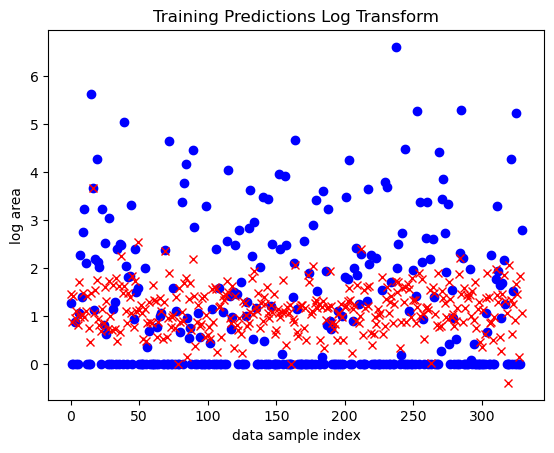

In [189]:
plt.plot(y_trn, 'ob')
plt.plot(y_hat_trn, 'xr')
plt.xlabel('data sample index')
plt.ylabel("log area")
plt.title("Training Predictions Log Transform")
plt.show()

Well, it doesn't look awful, but it's also hard to tell which prediction lines up with which label. We can short of tell most of our predictions are centered around the value 1.

We can confirm this by looking at the mean and STD of our predictions.

In [190]:
y_hat_trn.mean()

1.1587072234679385

In [191]:
y_hat_trn.std()

0.4730434660946132

Note if we wanted to convert our predictions for the 'area' back to thier original units, which were given in [hectare](https://en.wikipedia.org/wiki/Hectare), we can reverse the log transform by doing $e^{y} -1$ as `np.log` uses log base $e$ by default.

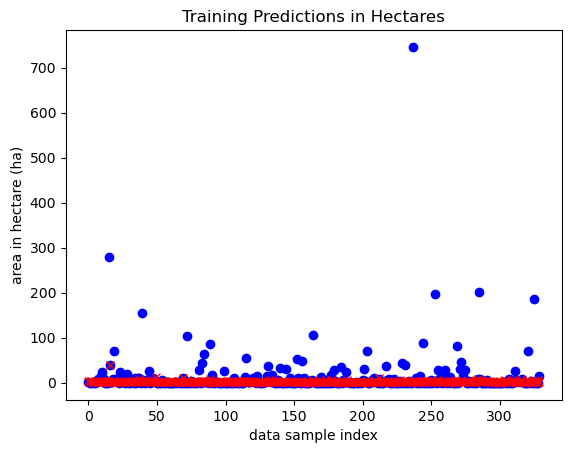

In [192]:
plt.plot(np.exp(y_trn)-1, 'ob')
plt.plot(np.exp(y_hat_trn)-1, 'xr')
plt.xlabel('data sample index')
plt.ylabel("area in hectare (ha)")
plt.title("Training Predictions in Hectares")
plt.show()

Notice we can tell even less about what is happening since the units are too large and spread out.

Let's now compute our training error and some other performance measures for our data so we can get a better idea for how well the learned weights are modeling the training data. Recall we'll need to compute MSE to get a summary of how well our model is performing which is defined as follows:

$$
MSE  = \frac{1}{m}\sum_{i=0}^m (\hat{y} - y)^2
$$ 

Note that we are going to define a new cost function that acts as a very useful performance metric called *Root Mean Squared Error (RMSE)* which is defined as follows:

$$
RMSE  = \sqrt{\frac{1}{m}\sum_{i=0}^m (\hat{y} - y)^2}
$$ 

All this does is take the square root of the MSE which then cancels out the squared error. This allows us to **get our error in the same units as our target** 'area'.

#### TODO 9
Complete the following TODO by finishing the `error()`, `mse()`, and `rmse()` functions. 
1. Compute the error (difference) between our predictions `y_hat` and `y` (do NOT sum). Return the output.
2. Compute the MSE between our predictions `y_hat` and `y`. Return the output.
    1. Hint: Feel free to call the `error()` function as part of this function if you want.
    1. Hint: try using the NumPy `mean()` function and refer to out notes if you get stuck.
3. Compute the RMSE between our predictions `y_hat` and `y`. Return the output.
    1. Hint: Feel free to call the `mse()` function as part of this function if you want.
    2. Hint: try using the NumPy `sqrt()` function,


*Below we also define a function called `performance_measures()` which will compute and return our errors, SSE, MSE, and RMSE!*

In [193]:
def error(y, y_hat):
    # TODO 9.1
    return y - y_hat 

def mse(y, y_hat):
    # TODO 9.2
    return np.mean((y - y_hat)**2)

def rmse(y, y_hat):
    # TODO 9.3
    return np.sqrt(mse(y, y_hat))

def performance_measures(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray]:
    err = error(y, y_hat)
    sse = np.sum(err**2)
    mse_ = mse(y, y_hat)
    rmse_ = rmse(y, y_hat)
    return err, sse, mse_, rmse_


Run the below code to check your implementations. Take a second to observe the values for MSE, RMSE, and SSE.

In [194]:
trn_scores = performance_measures(y=y_trn, y_hat=y_hat_trn)
trn_error, trn_sse, trn_mse, trn_rmse = trn_scores

print(f"Train MSE: {trn_mse}")
print(f"Train RMSE: {trn_rmse}")
print(f"Train SSE: {trn_sse}")

todo_check([
    (np.isclose(trn_mse, 1.797454941360022, rtol=.01), 'trn_mse values is wrong!'),
    (np.isclose(trn_rmse, 1.3406919636366967, rtol=.01),'trn_rmse values is wrong!'),
    (np.isclose(trn_sse, 593.1601306488072, rtol=.01),'trn_sse values is wrong!'),
])

Train MSE: 1.7974549413600216
Train RMSE: 1.3406919636366967
Train SSE: 593.1601306488071
Your code PASSED the code check!


Hmm the question is whether our MSE and RMSE values are good. We'll take a deeper look at the answer to this question here soon. First, let's quickly define the function `analyze()` which computes our performance measure scores and plots our targets/predictions for us. Then, let's see what our validation scores are like!

In [195]:
def analyze(
    y: np.ndarray, 
    y_hat: np.ndarray,
    title: str, 
    dataset: str,
    xlabel: str = None,
    ylabel: str = None
) -> Tuple[np.ndarray]:
    """ Plot your results and compute perforamnce measures 
        using your predictions and labels.
    """
    
    err, sse, mse_, rmse_ = performance_measures(y=y, y_hat=y_hat)
    
    plt.plot(y, 'ob')
    plt.plot(y_hat, 'xr')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    print(f"{dataset} MSE: {mse_}")
    print(f"{dataset} RMSE: {rmse_}")
    print(f"{dataset} SSE: {sse}")
    
    return err, sse, mse_, rmse_

## Validation
Now let's see how our learned model performs on our validation data set.

#### TODO 10
Complete the todo by making predictions for our `X_vld` data.

1. Using our `ols` make predictions for our `X_vld` data using the `predict()` method. Store the output into `y_hat_vld`.

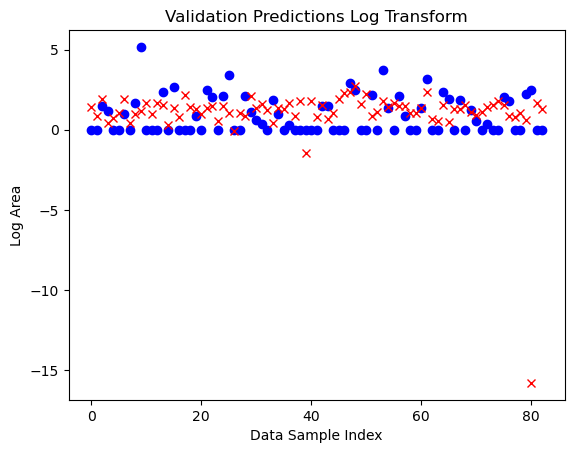

Validation MSE: 5.574843910551098
Validation RMSE: 2.3611107366134054
Validation SSE: 462.7120445757412
Your code PASSED the code check!


In [196]:
# TODO 10.1
y_hat_vld = ols.predict(X_vld)

vld_scores = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions Log Transform",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Log Area")

_, vld_sse, vld_mse, vld_rmse = vld_scores


todo_check([
    (np.isclose(vld_mse, 5.574843910551131, rtol=.01), 'vld_mse values is wrong!'),
    (np.isclose(vld_rmse, 2.3611107366134125, rtol=.01), 'vld_rmse values is wrong!'),
    (np.isclose(vld_sse, 462.7120445757439, rtol=.01), 'vld_sse values is wrong!'),
])

At first glance this plot looks better. However, we can see the RMSE and MSE are much higher than our training data. When transform the predictions back to hectares we can see some of our predictions are vastly off.

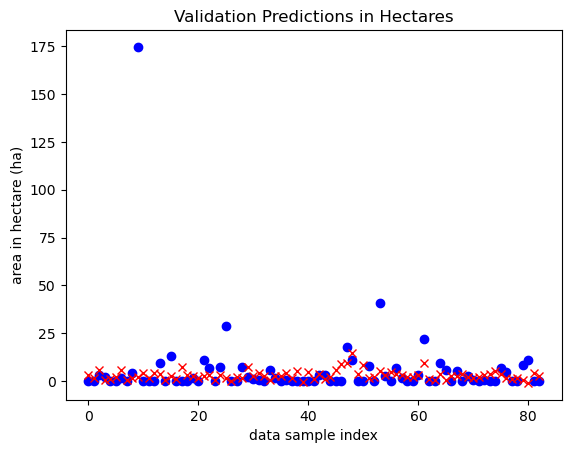

In [197]:
plt.plot(np.exp(y_vld)-1, 'ob')
plt.plot(np.exp(y_hat_vld)-1, 'xr')
plt.xlabel('data sample index')
plt.ylabel("area in hectare (ha)")
plt.title("Validation Predictions in Hectares")
plt.show()

## Analyzing Performance

### Looking at RMSE  performance

It turns out our MSE and RMSE values for our training and validation are actually pretty high.  

Let's focus on the RMSE for our analysis as the training and validation RMSE  tells us our error with respect to the original units. 
<!-- This means if our error for predicting stock market prices was 1.9 then on average our predictions are off by $1.90.  -->

In terms of our data, this tells us how many hectare (ha) on average our predictions are off by. Below is a visualize for the size of a hectare for reference.

![](https://i.pinimg.com/736x/66/2e/3e/662e3e176afae29d9c59e95f53675bd3--acre-vs.jpg)

Having a rough idea for the size of a hectare, let's see how much we are off on average. 

Below we define the `unlog()` function which will undo the log transformation that was applied to our targets 'area' and in turn is inherently applied to our predictions. Recall that since our targets `y` have had the log transform applied to them, our predictions will then try to predict values on the same scale. Thus, our RMSE will be given in the same scale as the predicted and target values.

#### TODO 11
Complete the TODO by defining the `unlog()` function by converting the equation $e^{x} -1$ for reversing the log transform into code. Recall we use $e^x$ as `np.log` uses log base $e$ by default.

1. Define a function called `unlog()`. It should take `x` its only argument.
    1. Convert the reverse of the log transform for any input `x` and return the output.
        1. Hint: Use the above equation to complete this TODO. You can use `np.exp()` function to represent the natural exponent $e$.

In [198]:
# TODO 11.1
def unlog(x):
    return np.exp(x)-1


trn_rmse_ha = unlog(trn_rmse)
vld_rmse_ha = unlog(vld_rmse)

print(f"Train RMSE: {trn_rmse_ha} ha")
print(f"Validation RMSE: {vld_rmse_ha} ha")

todo_check([
    (np.isclose(trn_rmse_ha,  2.8216870591, rtol=.01), 'trn_rmse_ha value is incorrect!'),
    (np.isclose(vld_rmse_ha,  9.6027217456, rtol=.01), 'vld_rmse_ha value is incorrect!'),
])

del trn_rmse_ha, vld_rmse_ha

Train RMSE: 2.8216870591150642 ha
Validation RMSE: 9.602721745620475 ha
Your code PASSED the code check!


So we can see our model is, on average, ~3 ha off a given training data sample while our model is ~10 ha off a given validation data sample. Depending on the accuracy needed this might be acceptable. However, ~10 ha off our validation data (i.e., unseen data) seems like a lot.

### Analyzing targets/labels

So what might the issue be here? Why is our RMSE pretty high, even more so for validation data? We'll one issue is that our targets have a skewed distribution. Even with the log transform our targets are still skewed. See the below plot as a reminder. 

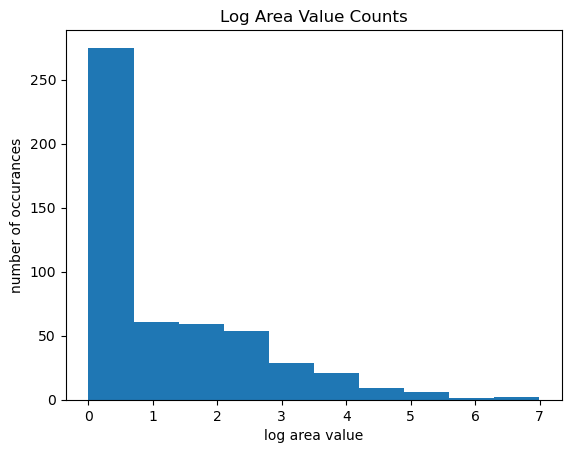

In [199]:
# Apply pre-split cleaning
cleaner_df = before_pipeline(forestfire_df)
# Apply feature and label splitting
X, y = feature_label_split(cleaner_df)

plt.hist(y)
plt.xlabel('log area value')
plt.ylabel('number of occurances')
plt.title("Log Area Value Counts")
plt.show()

del X, y, cleaner_df

So why does a skewed or heavy tailed distribution distort our results? This relates to another issue regarding **data balance**. If we recall many of our target values (burned forest area values) were 0. However, a further issue is that many of our none zero values are also near zero! Having so many values near and at 0 can influence our predictions by biasing the algorithm towards predicting values closer to 0.
The model will predict lots of zeros lazily. 

Further, it is typical for validation scores to be worse than training scores as the data has not been seen before. However, if your validation RMSE or MSE is much significantly higher, this could indicate our model is overfitting to the training data and thus failing to generalize to new unseen data! 

### Analyzing weight values

Let's now look at our weights. What do you think the weight values represent?

In [200]:
ols.w

array([ 1.15870722,  0.17463344,  0.0469797 ,  0.0726667 ,  0.36799776,
       -0.65727664, -0.05196925,  0.24519706,  0.10619986,  0.06702135,
       -0.12916433, -0.1576489 , -0.0900321 ,  0.17030006, -0.04714236,
       -0.01147216, -0.0955457 , -0.14109477, -0.28416465,  0.11462751,
       -0.08519655,  0.10327673,  0.37139444, -0.05217581,  0.02084817,
        0.07904557, -0.05881664, -0.00309924,  0.07641145, -0.04991833])

Notice the largest weight is for the bias as this controls the y-intercept.(We can think of the bias as controlling a y-intercept like value however since we are using multiple features then we are no longer in 2D space!) 

Further, a bonus of linear models is that we can roughly regard the absolution value of a weight as the importance of the weight. (Note that negative values don't hold any particular significance so we take the absolute value.) However, we can only say this if **all** our features are operating on the same scale. Since we standardized our data we can say this is approximately true! 

Below is check to make sure our data is all operating on a similar scale (mean of 0, STD of 1).

In [201]:
X_trn_df, y_trn_df, _, _, _, _ = data_prep(forestfire_df)
display(X_trn_df.describe())


,bias,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
count,330.0,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,...,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02
mean,1.0,4.575465e-17,-1.668699e-16,-9.689219e-17,4.575465e-17,1.614870e-17,6.055762e-17,-1.735985e-16,-1.231338e-16,-2.987509e-16,...,1.076580e-17,1.076580e-17,6.459479e-17,2.960595e-17,1.076580e-17,-1.614870e-17,-2.691450e-18,1.614870e-17,5.382900e-17,9.420074e-18
std,0.0,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,...,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00
min,1.0,-1.580814e+00,-1.959981e+00,-1.191567e+01,-1.675169e+00,-2.132400e+00,-2.254453e+00,-2.907805e+00,-1.800277e+00,-1.796233e+00,...,-5.513178e-02,-1.767767e-01,-7.216213e-01,-4.569368e-01,-4.275461e-01,-4.125685e-01,-5.000000e-01,-3.660883e-01,-3.499271e-01,-3.333333e-01
25%,1.0,-7.077283e-01,-2.466202e-01,-5.234042e-02,-6.208716e-01,-4.537831e-01,-6.345568e-01,-5.949835e-01,-7.135243e-01,-7.637554e-01,...,-5.513178e-02,-1.767767e-01,-7.216213e-01,-4.569368e-01,-4.275461e-01,-4.125685e-01,-5.000000e-01,-3.660883e-01,-3.499271e-01,-3.333333e-01
50%,1.0,-2.711856e-01,-2.466202e-01,1.799485e-01,-5.288217e-02,4.609065e-01,-9.459135e-02,5.330746e-02,-1.701481e-01,-1.807705e-02,...,-5.513178e-02,-1.767767e-01,-7.216213e-01,-4.569368e-01,-4.275461e-01,-4.125685e-01,-5.000000e-01,-3.660883e-01,-3.499271e-01,-3.333333e-01
75%,1.0,9.293068e-01,6.100604e-01,3.914973e-01,4.455267e-01,6.701881e-01,4.710867e-01,6.972180e-01,5.392597e-01,7.849612e-01,...,-5.513178e-02,-1.767767e-01,1.385768e+00,-4.569368e-01,-4.275461e-01,-4.125685e-01,-5.000000e-01,-3.660883e-01,-3.499271e-01,-3.333333e-01
max,1.0,1.911528e+00,4.036783e+00,9.431834e-01,2.714459e+00,1.250622e+00,3.582316e+00,2.506300e+00,3.331610e+00,3.079356e+00,...,1.813836e+01,5.656854e+00,1.385768e+00,2.188487e+00,2.338929e+00,2.423840e+00,2.000000e+00,2.731582e+00,2.857738e+00,3.000000e+00


With this idea of importance in mind, we can take the absolute value of our weights and sort them from largest to smallest and see what features our model is "valuing" the most. Below we get the indexes of the weights who have the largest absolute value in descending order (largest to smallest).

In [202]:
top_index = np.abs(ols.w).argsort()[::-1]
top_index

array([ 0,  5, 22,  4, 18,  7,  1, 13, 11, 17, 10, 19,  8, 21, 16, 12, 20,
       25, 28,  3,  9, 26, 23,  6, 29, 14,  2, 24, 15, 27])

Next, we can sort our original weights in descending order.

In [203]:
ols.w[top_index]

array([ 1.15870722, -0.65727664,  0.37139444,  0.36799776, -0.28416465,
        0.24519706,  0.17463344,  0.17030006, -0.1576489 , -0.14109477,
       -0.12916433,  0.11462751,  0.10619986,  0.10327673, -0.0955457 ,
       -0.0900321 , -0.08519655,  0.07904557,  0.07641145,  0.0726667 ,
        0.06702135, -0.05881664, -0.05217581, -0.05196925, -0.04991833,
       -0.04714236,  0.0469797 ,  0.02084817, -0.01147216, -0.00309924])

Lastly, we can get the names of the features in descending order of "importance" based on the highest weights.

In [204]:
pd.DataFrame(ols.w[top_index], index=X_trn_df.columns[top_index], columns=['weight'])

,weight
bias,1.158707
DC,-0.657277
month_sep,0.371394
DMC,0.367998
month_mar,-0.284165
temp,0.245197
X,0.174633
month_dec,0.170300
month_apr,-0.157649
month_jun,-0.141095


Notice that most of the 'day' features are ranked really low. In theory, would knowing the day really influence when a fire might occur? Recall in the data visualization lab the day feature almost seemed randomly distributed (see visualization below)! *Maybe we could drop these features from our data since their corresponding weights seem to be very low aren't adding a lot.*

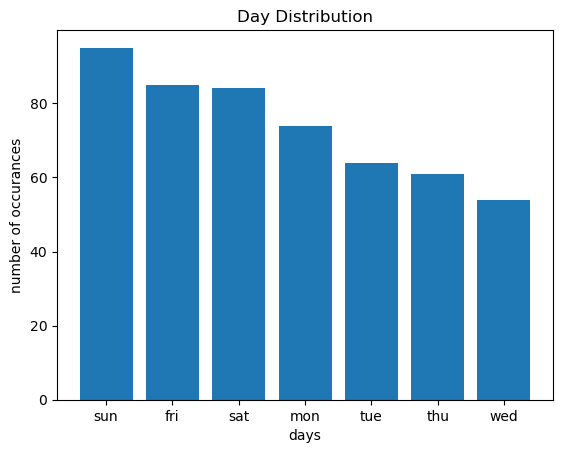

In [205]:
day_counts = forestfire_df['day'].value_counts()
plt.bar(day_counts.index, day_counts.values)
plt.xlabel('days')
plt.ylabel('number of occurances')
plt.title("Day Distribution")
plt.show()

### Checking remaining linear assumptions

Let's check our remaining linear model assumptions to see if our poor results can be explained by having poor data.

#### Equal variance (Homoscedsticity)
Recall that this check refers to seeing if the variance of our errors/residuals are approximately equal. We can check this by ploting our errors against our predicting. We are looking for a plot where all the errors essentially form  a rectangle-like pattern. If equal variance does not hold we will see more of a cone shape. See the below visualization.

<img src=https://dataaspirant.com/wp-content/uploads/2020/12/10-Homoscedasticity-Vs-Heteroscedasticity.png width=500, height=500>

**Homoscedsticity means the larger error occur to the larger predicted values. Thus, the error is not dependent on the values/scales of the labels.**
For example, for two samples with area of 1 (sample A) and 10 (sample B), respectively. We make predictions to them as 1.1 and 11. Although the error at sample B is ten times larger than the error at sample A, the variances for them are both 10%. Thus, the error is not related to the scale of the predicted value. This is why it's called **equal variance**.


Based on our below graph our errors seem to be roughly have equal variance. however, there is a slight abnormality around 0 which recall most of our targets are centered around 0!

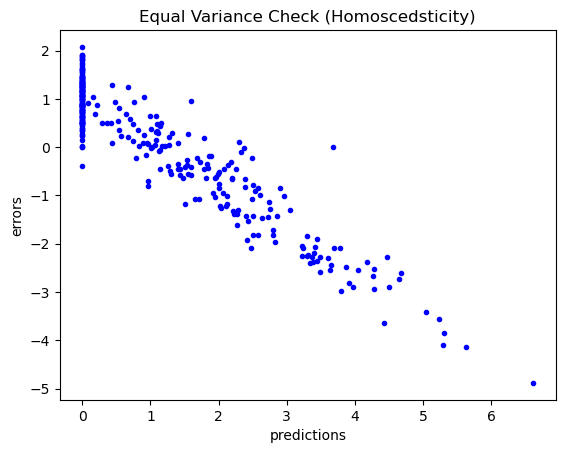

In [206]:
trn_error = error(y_hat_trn, y_trn)
plt.plot(y_trn, trn_error, 'b.')

plt.title(f"Equal Variance Check (Homoscedsticity)")
plt.ylabel('errors')
plt.xlabel('predictions')
plt.show();

#### Normality of errors

Next we need to check if our errors are normally distributed. We can do so using an Q-Q plot or plotting the distribution of our errors.

For those that don't know, a Q-Q plot or quantile-quantile plot is a graphical way of comparing two distributions. In our case, we want to check our error distribution against the normal or Gaussian distribution. 

In the below plot our error values are marked by the blue dots and the theoretical normal or Gaussian are indicated by the red line. If our errors are normally distributed they should follow the red line. You can see our values slightly diverge from the line on the ends. However, this divergence isn't too major and thus we might be able to claim our errors are roughly normally distributed. 

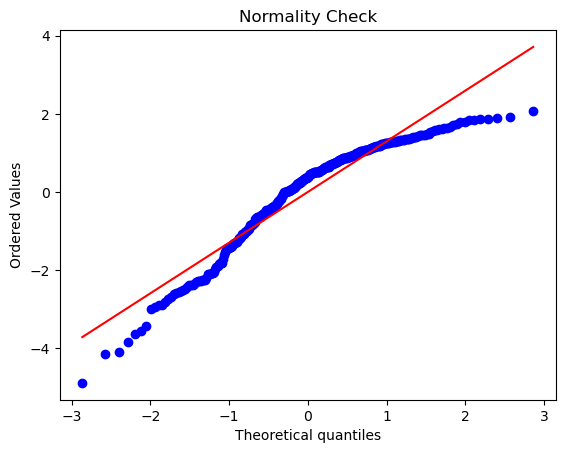

In [207]:
# Normality of errors
import scipy.stats as stats
stats.probplot(trn_error.reshape(-1,), dist="norm", plot=plt)
plt.title(f"Normality Check")
plt.show()

Alternatively we can simply use a histogram to plot our errors and see if the error distribution looks something like a normal distribution. Recall a normal distribution looks like the following

<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fmichaelminn.net%2Ftutorials%2Fr-normal-rank-order%2Fbell-curve.png&f=1&nofb=1" width=500 height=500>

Thus, our histogram should match the shape of a the normal distribution if our errors are truly normally distributed. Below we do so using **Seaborn**, a high-level wrapper for matplotlib that makes nicer looking plots by default (more on Seaborn in future labs).

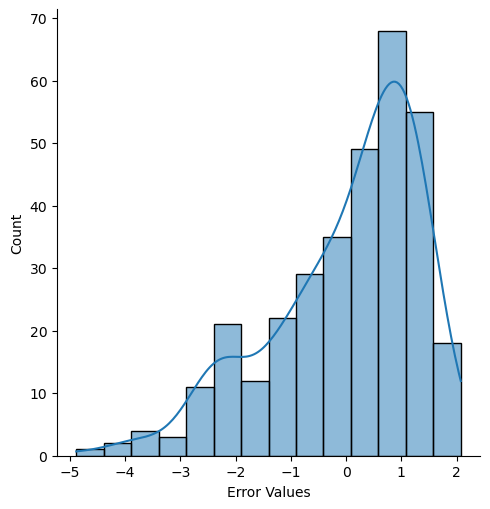

In [208]:
import seaborn as sns
sns.displot(trn_error, kde=True);
plt.xlabel("Error Values")
plt.show();

Once again we notice that our errors are slightly skewed, meaning we don't fully meet the normality check.

#### Did we meet the liner assumptions?

Based on the results we can conclude that we approximately meet our assumptions, however it isn't super clear cut. As we can see this is reflected in the performance of our results as our results aren't horrid but they aren't great either.

Most of the time it actually might be faster to just test your data on a linear model and see how it performs. Getting stuck on the assumptions too much might be too time consuming, however this will depend on your problem at hand. The big assumption to pay attention to is our first assumption of linearity.

<!-- *Note we did not check for independence of errors as our data is not time-series data. Thus, we do not know the order our data was collected in and it is hard to check for independence if this is not known.* -->

In [209]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse'])

## Training with certain features

Recall that while analysis our weights it seem like the 'day' features received very small weights and thus could be interpreted as being of less "importance." Let's check this observation and see how our OLS model performs when we drop these features.

In [210]:
drop_features = ['day_sat', 'day_tue', 'day_sun', 'day_fri', 'day_wed','day_mon','day_thu']
drop_features

['day_sat', 'day_tue', 'day_sun', 'day_fri', 'day_wed', 'day_mon', 'day_thu']

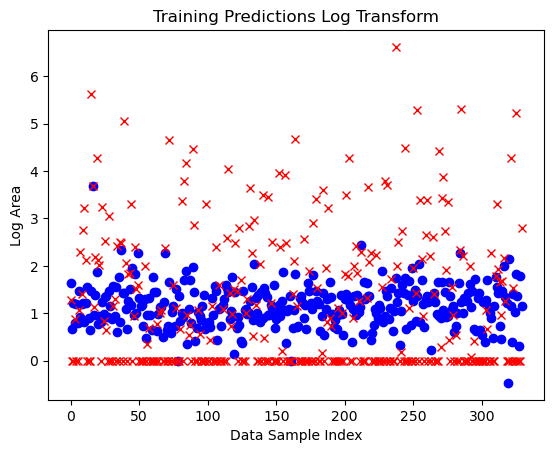

Training MSE: 1.8207379826417998
Training RMSE: 1.349347243166784
Training SSE: 600.8435342717939


In [211]:
# Get our data and return them as NumPy arrays
X_trn, y_trn, X_vld, y_vld, _, _ = data_prep(forestfire_df,
                                             drop_features=drop_features,
                                             return_array=True)

ols = OrdinaryLeastSquares()
# Fit our data and learn "best" weights for training data
ols.fit(X_trn, y_trn)
# Check how well our weights learned our TRAIN data
y_hat_trn = ols.predict(X_trn)

_, trn_sse, trn_mse, trn_rmse = analyze(y_hat_trn, y_trn,
                                        title="Training Predictions Log Transform",
                                        dataset="Training",
                                        xlabel="Data Sample Index",
                                        ylabel="Log Area")

Well our training error doesn't seem any better does it? If anything it seems to have gotten slightly worse as our previous RMSE was ~1.340 and the current RMSE is ~1.349. Before we make any conclusions let's check our performance on the validation data and see how it is doing.

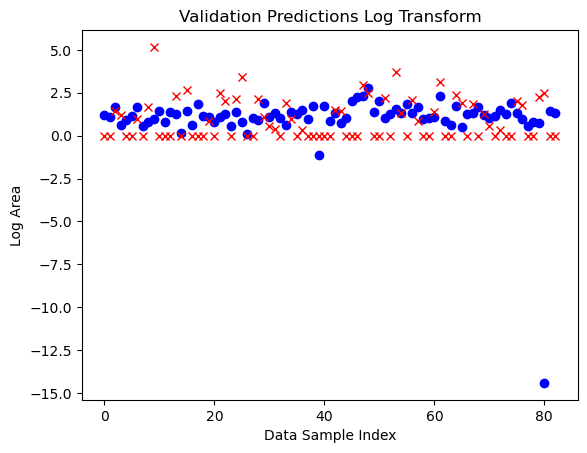

Validation MSE: 4.91955882826687
Validation RMSE: 2.218007851263577
Validation SSE: 408.3233827461502


In [212]:
y_hat_vld = ols.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(y_hat_vld, y_vld,
                                        title="Validation Predictions Log Transform",
                                        dataset="Validation",
                                        xlabel="Data Sample Index",
                                        ylabel="Log Area")

Interesting! Our previous validation RMSE was about ~2.36 and the current RMSE is ~2.21. Our validation scores have actually slightly improved! This could indicate that our model could be slightly overfitting to our the the 'day' feature when training!

Recall that overfitting means our model is fitting to noise in the data that doesn't actually server as a useful predictor when used for unseen data! **In short, overfitting means: good training performance but worse validation/test performance.** In this case, our model might be using some pattern in 'day' feature that is only present in our training data and not in our unseen data - leading to decreased performance on unseen data. 


In [213]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'data_features'])

# **Gradient Descent** Review

Before we get to least means squared, let's start off simple and review the concept of gradient descent by looking at a toy problem.

## Toy Example: Minimizing $x^2$

Below we can see a toy example of gradient descent in action. Given some x-y coordinate starting point on a function, in particular the $x^2$ function, we want to find the minimum. To do so, we can simply use the idea of gradient descent to slowly move from our starting x-y position to the minimum of the $x^2$ function. Since the $x^2$ function is essentially just a bowl the minimum will be at 0. 

Remember from calculus class that we could directly solve for the minimum by taking the derivative of our function and setting it equal to $f'(x) = 0$ and then solve for $x$ (like we did for ordinary least squares)! For more complex functions (like neural networks) and problems where the data has too many features or is too large to fit into memory we need to iteratively approximate the minimum. To do this we use gradient descent!

Below we define a helper plotting function called `plot_function()` which will plot any passed mathematical function. 

In [214]:
def plot_function(f, steps=100, xlabel=None, ylabel=None, title=None, min_ls=-1, max_ls=1, ax=None, figsize=(6,4)):
    x = np.linspace(min_ls, max_ls,steps)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if xlabel is not None: 
        ax.set_xlabel(xlabel)
    if ylabel is not None: 
        ax.set_ylabel(ylabel)
    if title is not None: 
        ax.set_title(title)

Additionally, we also define our $x^2$ function using the `f()` function and the derivative $2x$ using the `f_prime()` function as we will be using these our gradient descent toy problem.

In [215]:
def f(x):
    return x**2

def f_prime(x):
    return 2*x

Here we use our `plot_function()` function to plot our $x^2$ function `f()`. Next, we can plot the starting coordinate (1,1) for our gradient descent problem using `x_start` and `y_start`. **The starting point will always be represented by the green dot!**

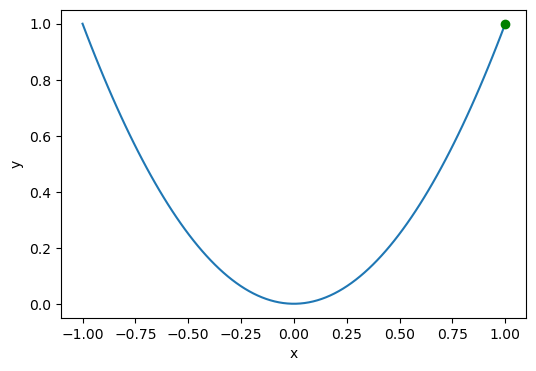

In [216]:
x_start = 1 
y_start = f(x_start)

plot_function(f, xlabel='x', ylabel='y')

plt.plot(x_start, y_start, 'go')

Alright, we have our function and our starting point plotted! Now we just need to find our way to the minimum at (0, 0) using the gradient descent algorithm.

#### TODO 12
Complete the TODO by finishing the `gradient_descent()` function.

1. Compute the y coordinate for the passed input `x`. Do so by simply passing `x` to the passed function `f()`. Store the output into `y`.

2. Compute the gradient at the current x coordinate. Do so by simply passing `x` to the passed derivative function `f_prime()`. Store the output into `dx`.

3. Take a gradient step and update the x coordinate (the updated x is still named as x):
> Take a gradient step by using the gradient update equation $x = x - \alpha \nabla f(x)$. Store the output into `x`.
> > Hint 1: $\alpha$ refers to the learning rate `lr`.
> > Hint 2: $\nabla f(x)$ refers to the gradient of $f(x)$. Recall we already computed the gradient and stored the output into `dx`!
 
4. Update the y coordinate for our new x coordinate. Do so by simply passing `x` to the passed function `f()`. Store the output into `y`.

In [217]:
def gradient_descent(x: float, f: Callable, f_prime: Callable, n_iter: int = 10, lr: float = .1):
    """ Performs gradient descent given a passed function and its derivative
    
        Args:
            x: The starting x coordiante where GD will start from.
            
            f: A callable function that contains the desired function GD will
                try to find a minimum for.
                
            f_prime: The derivative of the function 'f' which is also a callable 
                function.
            
            n_iter: The number of gradient descent steps to take
            
            lr: The learning rate which determines the step size for 
                each gradient descent step.
    
    """
    
    # TODO 12.1
    y = f(x)
    
    x_hist = [x]
    y_hist = [y]

    for i in range(n_iter):
        # TODO 12.2
        dx = f_prime(x)
        
        print("(x, y): ({:.3f}, {:.3f}), Grad: {:.4f}, Scaled-grad: {:.4f}".format(
             x, y, dx, dx*lr)
             )
        
        # TODO 12.3
        x = x - lr * dx
    
        # TODO 12.4
        y = f(x)

        # Track the x and y position history
        x_hist.append(x)
        y_hist.append(y)

        # Convergence check to see if gradient is near zero!
        # In other words, check if gradient is near a minimum!
        # Recall that when the gradient equals zero we are either
        # near a local minimum, local maximum, or saddle point!
        if abs(dx) <= .001:
            break
        
    print("Total iterations taken: {}".format(i))
    return x_hist, y_hist

(x, y): (1.000, 1.000), Grad: 2.0000, Scaled-grad: 0.2000
(x, y): (0.800, 0.640), Grad: 1.6000, Scaled-grad: 0.1600
(x, y): (0.640, 0.410), Grad: 1.2800, Scaled-grad: 0.1280
(x, y): (0.512, 0.262), Grad: 1.0240, Scaled-grad: 0.1024
(x, y): (0.410, 0.168), Grad: 0.8192, Scaled-grad: 0.0819
(x, y): (0.328, 0.107), Grad: 0.6554, Scaled-grad: 0.0655
(x, y): (0.262, 0.069), Grad: 0.5243, Scaled-grad: 0.0524
(x, y): (0.210, 0.044), Grad: 0.4194, Scaled-grad: 0.0419
(x, y): (0.168, 0.028), Grad: 0.3355, Scaled-grad: 0.0336
(x, y): (0.134, 0.018), Grad: 0.2684, Scaled-grad: 0.0268
(x, y): (0.107, 0.012), Grad: 0.2147, Scaled-grad: 0.0215
(x, y): (0.086, 0.007), Grad: 0.1718, Scaled-grad: 0.0172
(x, y): (0.069, 0.005), Grad: 0.1374, Scaled-grad: 0.0137
(x, y): (0.055, 0.003), Grad: 0.1100, Scaled-grad: 0.0110
(x, y): (0.044, 0.002), Grad: 0.0880, Scaled-grad: 0.0088
(x, y): (0.035, 0.001), Grad: 0.0704, Scaled-grad: 0.0070
(x, y): (0.028, 0.001), Grad: 0.0563, Scaled-grad: 0.0056
(x, y): (0.023

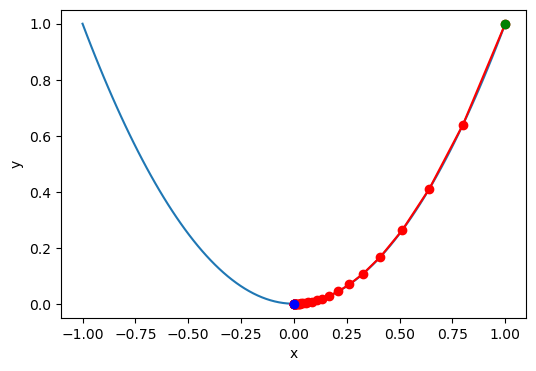

In [218]:
x_hist, y_hist = gradient_descent(x_start, f, f_prime, n_iter=100, lr=.1)

todo_check([
    (np.all(np.isclose(x_hist[1:4], [.8, .64, .512], rtol=.01)), 'Gradient values were incorrect!'),
])

# Plot the x^2 function
plot_function(f, xlabel='x', ylabel='y')
# Plot the history of x-y coordinates (i.e., steps taken)
plt.plot(x_hist, y_hist, 'ro-')
# Plot start position
plt.plot(x_hist[0], y_hist[0], 'go')
# Plot end position
plt.plot(x_hist[-1], y_hist[-1], 'bo');

del x_hist, y_hist

You might be wondering, well, if we take smaller and smaller steps near the minimum why don't we just increase the learning rate so then we can take larger steps near the minimum.

Let's see what happens when we pass a large learning rate of $0.9$.

(x, y): (1.000, 1.000), Grad: 2.0000, Scaled-grad: 1.8000
(x, y): (-0.800, 0.640), Grad: -1.6000, Scaled-grad: -1.4400
(x, y): (0.640, 0.410), Grad: 1.2800, Scaled-grad: 1.1520
(x, y): (-0.512, 0.262), Grad: -1.0240, Scaled-grad: -0.9216
(x, y): (0.410, 0.168), Grad: 0.8192, Scaled-grad: 0.7373
(x, y): (-0.328, 0.107), Grad: -0.6554, Scaled-grad: -0.5898
(x, y): (0.262, 0.069), Grad: 0.5243, Scaled-grad: 0.4719
(x, y): (-0.210, 0.044), Grad: -0.4194, Scaled-grad: -0.3775
(x, y): (0.168, 0.028), Grad: 0.3355, Scaled-grad: 0.3020
(x, y): (-0.134, 0.018), Grad: -0.2684, Scaled-grad: -0.2416
(x, y): (0.107, 0.012), Grad: 0.2147, Scaled-grad: 0.1933
(x, y): (-0.086, 0.007), Grad: -0.1718, Scaled-grad: -0.1546
(x, y): (0.069, 0.005), Grad: 0.1374, Scaled-grad: 0.1237
(x, y): (-0.055, 0.003), Grad: -0.1100, Scaled-grad: -0.0990
(x, y): (0.044, 0.002), Grad: 0.0880, Scaled-grad: 0.0792
(x, y): (-0.035, 0.001), Grad: -0.0704, Scaled-grad: -0.0633
(x, y): (0.028, 0.001), Grad: 0.0563, Scaled-gra

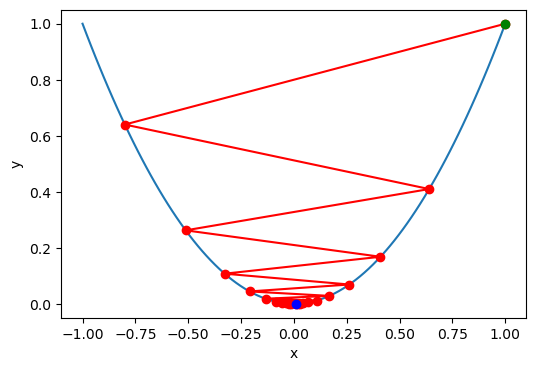

In [219]:
x_hist, y_hist = gradient_descent(x_start, f, f_prime, n_iter=20, lr=.9)

# Plot the x^2 function
plot_function(f, xlabel='x', ylabel='y')
# Plot the history of x-y coordinates (i.e., steps taken)
plt.plot(x_hist, y_hist, 'ro-')
# Plot start position
plt.plot(x_hist[0], y_hist[0], 'go')
# Plot end position
plt.plot(x_hist[-1], y_hist[-1], 'bo');

del x_hist, y_hist

Well, it turns out we will still find our way to a minimum but our path there is quite a bit more chaotic. If we increase the learning rate any further gradient descent might just become even more unstable and either not find the minimum or completely overshoot it!

Likewise, let's see what happens when we pass a really small learning rate of $0.001$. 

(x, y): (1.000, 1.000), Grad: 2.0000, Scaled-grad: 0.0020
(x, y): (0.998, 0.996), Grad: 1.9960, Scaled-grad: 0.0020
(x, y): (0.996, 0.992), Grad: 1.9920, Scaled-grad: 0.0020
(x, y): (0.994, 0.988), Grad: 1.9880, Scaled-grad: 0.0020
(x, y): (0.992, 0.984), Grad: 1.9840, Scaled-grad: 0.0020
(x, y): (0.990, 0.980), Grad: 1.9801, Scaled-grad: 0.0020
(x, y): (0.988, 0.976), Grad: 1.9761, Scaled-grad: 0.0020
(x, y): (0.986, 0.972), Grad: 1.9722, Scaled-grad: 0.0020
(x, y): (0.984, 0.968), Grad: 1.9682, Scaled-grad: 0.0020
(x, y): (0.982, 0.965), Grad: 1.9643, Scaled-grad: 0.0020
(x, y): (0.980, 0.961), Grad: 1.9604, Scaled-grad: 0.0020
(x, y): (0.978, 0.957), Grad: 1.9564, Scaled-grad: 0.0020
(x, y): (0.976, 0.953), Grad: 1.9525, Scaled-grad: 0.0020
(x, y): (0.974, 0.949), Grad: 1.9486, Scaled-grad: 0.0019
(x, y): (0.972, 0.945), Grad: 1.9447, Scaled-grad: 0.0019
(x, y): (0.970, 0.942), Grad: 1.9408, Scaled-grad: 0.0019
(x, y): (0.968, 0.938), Grad: 1.9370, Scaled-grad: 0.0019
(x, y): (0.967

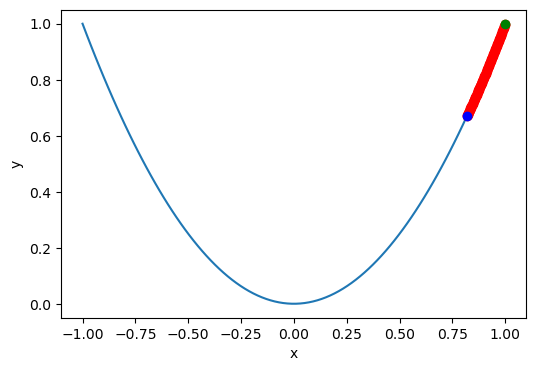

In [220]:
x_hist, y_hist = gradient_descent(x_start, f, f_prime, n_iter=100, lr=.001)

# Plot the x^2 function
plot_function(f, xlabel='x', ylabel='y')
# Plot the history of x-y coordinates (i.e., steps taken)
plt.plot(x_hist, y_hist, 'ro-')
# Plot start position
plt.plot(x_hist[0], y_hist[0], 'go')
# Plot end position
plt.plot(x_hist[-1], y_hist[-1], 'bo');

del x_hist, y_hist

Notice even after 100 iterations we barely made it anywhere because our steps were too small. This means we would require loads more iterations before making it to the minimum and depending on the complexity of the problem this could be very time consuming!

# Least Mean Squares 

Finally, let's practice *Least Means Squares (LMS)*, the online and iterative linear regression algorithm. Recall that the following equation is the update rule for slowly moving our weights towards achieving the smallest training error and hopefully the most optimal weights:

$$
\begin{align}
\wv_{k+1} &=  \wv_{k} - \alpha \nabla J(\wv_{k}) \\
&= \wv_{k} - \alpha \Big( {\wv_{k}}^\top \xv_i - y_i \Big) \xv_i.\\
&= \wv_{k} - \alpha \Big( \hat{y} - y_i \Big) \xv_i.
\end{align}
$$

Here $\wv_k$ is the current weight vector where each element corresponding to an input feature. $\wv_{k+1}$ indicates the weights after being updated using  the current data sample $i$. $\xv_i$ is the current data samples or vector of input features and $y_i$ is the current target for said data sample. 

#### TODO 13
Complete the TODO by finishing the `LeastMeanSqaures` class. Reference the LMS algorithm in our notes for help on the TODOs.

1. First, complete the `self.predict()` method to which returns the prediction between our input data `X` and weights `self.w`. We'll be using this method to complete our `fit()` method as well!

2. Initialize the weights `self.w` randomly using our instance variable `rng` of NumPy's `np.random.RandomState` class. To do so, use `rng.rand()` and pass it the **number of features** in our input data `X` to set the shape of the weights vector.  Store the output back into our class variable `self.w`.
    1. Note: Recall we must have a weight for each feature in the data! Therefore, the shape of the weights must be a vector whose length is equal to *the number of features in the data*, including the added bias feature!
    
3. Make a prediction using our `self.predict()` method for the **CURRENT data sample indexed at `i`**. Do so by indexing the training data array `X` at index `i` to get the $i$th data sample and passing the data sample to  `self.predict()`. Store the output into `y_hat`.

4. Convert the weight update equation $\wv_{k+1} = \wv_{k} - \alpha \Big( \hat{y} - y_i \Big) \xv_i$ for the current data samples into code in order to update our weights `self.w`. Store the output into `self.w`.
    1. Hint: $k$ does not correspond to anything specific in code. It is simply a term to refer to the weights before $k$ and after being updated $k+1$. 
    1. Hint: $i$ does refer to our data `X` being indexed at the data sample index `i`. In our case, $i$ is the index used to access the current data sample.
    
5. Compute the predictions for the **ENTIRE training data `X`** using the `self.predict()` method. Store the output into `preds`.
    1. Note: This will allow us to see how well our model is doing at making predictions for the entire data after EACH weight update.
 
6. Compute the RMSE between **ALL the training data labels `y` and their corresponding predictions `preds`** by using the `rmse()` function. Store the output in `trn_rmse`.

In [221]:
import IPython.display as ipd  # for display and clear_output

class LeastMeanSqaures():
    def __init__(self, alpha=.001, epochs=1):
        self.w = None
        self.alpha = alpha
        self.epochs = epochs
        self.fig = plt.figure(figsize=(10,5))
        self.trn_err_hist = []
        
    def predict(self, X):
        # TODO 13.1
        return np.dot(X, self.w)
    
    def fit(self, X, y, weight_seed=1):
        m_samples = len(X)
        
        rng = np.random.RandomState(weight_seed)
        # TODO 13.2
        self.w = rng.rand(X.shape[1])
        
        print("Shape check...")
        print(f"\t X shape: {X.shape}")
        print(f"\t y shape: {y.shape}")
        print(f"\t w shape: {self.w.shape}")
        

        for e in range(self.epochs):
            for i in range(m_samples):
                print(f"\ty[i] shape: {y[i].shape}")
                print(f"\tX[i] shape: {X[i].shape}")
                
                # TODO 13.3
                y_hat = self.predict(X[i])
                print(f"\ty_hat shape: {y_hat.shape}")

                # TODO 13.4
                self.w = self.w - self.alpha * (y_hat - y[i]) * X[i]

                # TODO 13.5 
                preds = self.predict(X)

                # We need to reshape our preds to be a 2D array
                # otherwise when we compute (preds - y)**2 we will
                # get an array of shape (100, 100) instead of a (100, 1)
                # this is due to the automatic broadcasting NumPy does!
                preds = preds.reshape(-1, 1)
                
                # TODO 13.6
                # the trn_rmse stores the RMSE of the current sample  `x[i]`
                trn_rmse = rmse(y, preds)
                self.trn_err_hist.append(trn_rmse) #Don't change this line. 
                # After the loop across all samples, the self.trn_err_hist stores the trn_rmse for all samples.
                
                # plot
                self._plot_rmse_hist()
        ipd.clear_output(wait=True)
    

    def _plot_rmse_hist(self):

        plt.clf()
        # Training RMSE tracking (left graph)
        plt.subplot(1, 2, 1)
        plt.plot(self.trn_err_hist)
        plt.ylabel(f"Training RMSE")
        plt.xlabel("Data Sample")
        plt.title(f"RMSE History -  Current RMSE: {self.trn_err_hist[-1]}")
        
        # clear display
        ipd.clear_output(wait=True)
        ipd.display(self.fig)
        

Run the **two code cells below** to check your implementation of the `LeastMeanSqaures` class. 

**Warning: The below code can take ~30 seconds, longer or shorter depending on your computer!**


Notice that we plot the RMSE value for our entire training dataset every time we update our weights (each iteration). Since we update our weights for each data sample we can see that over time the RMSE value decreases, but not by a lot. Updating our model for each individual sample often leads to very chaotic learning if we use larger learning rates. 

Thus, our learning rate is very small $0.0001$ which makes learning slow. We can run multiple epochs to further try and reduce the RMSE but we could begin to overfit if we aren't too careful. In coming weeks we'll look at how to improve the gradient descent algorithm to get better results!

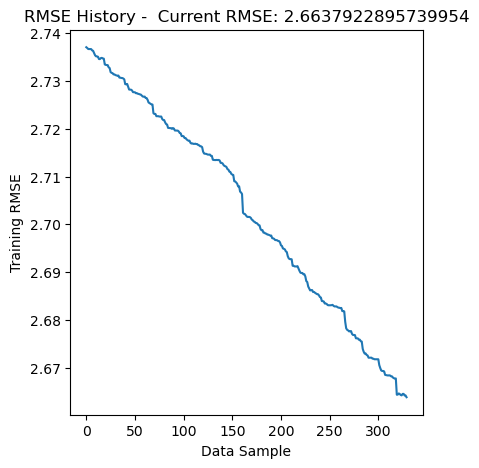

In [222]:
# Get our data and return them as NumPy arrays
X_trn, y_trn, X_vld, y_vld, _, _ = data_prep(forestfire_df, 
                                             return_array=True)


lms = LeastMeanSqaures(alpha=0.0001, epochs=1)
lms.fit(X_trn, y_trn)
y_hat_trn = lms.predict(X_trn)

Let's analyze our model by plotting the predictions and reviewing the performance measures.

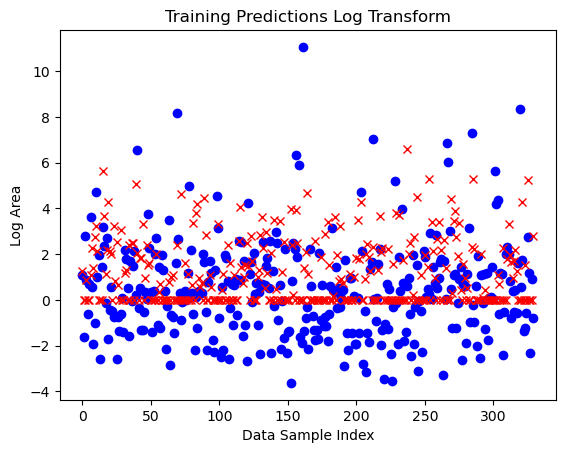

Training MSE: 6.815870826409639
Training RMSE: 2.6107222805977734
Training SSE: 2249.2373727151808
Your code PASSED the code check!


In [223]:
_, trn_sse, trn_mse, trn_rmse = analyze(y_hat_trn, y_trn,
                                        title="Training Predictions Log Transform",
                                        dataset="Training",
                                        xlabel="Data Sample Index",
                                        ylabel="Log Area")

todo_check([
    (np.isclose(trn_mse, 6.81587082640964, rtol=.01), 'trn_mse values is incorrect!'),
    (np.isclose(trn_rmse, 2.6107222805977734, rtol=.01), 'trn_rmse values is incorrect!'),
    (np.isclose(trn_sse, 2249.237372715181, rtol=.01), 'trn_sse values is incorrect!'),
])

Notice that our training MSE an RMSE are much higher than OLS which had a RMSE around ~1.34. Once agian, this most likely because we are updating our model for every data sample which leads to our model making vast changes from data sample to data sample even when a small learning rate is used. Additionally, since we are using smaller learning rates we might need to run more epochs in order to see similar MSE and RMSE scores to OLS (feel free to try this above but expect the `todo_check` to fail).

Let's see if these higher scores are reflected in our validation data.

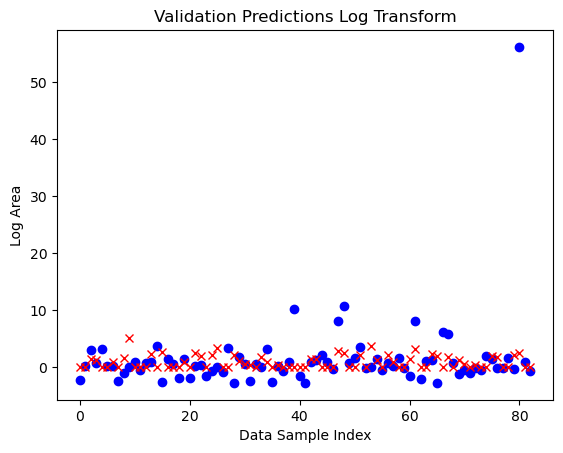

Validation MSE: 41.917224332949274
Validation RMSE: 6.47435126734326
Validation SSE: 3479.12961963479


In [232]:
y_hat_vld = lms.predict(X_vld)

_, vld_sse, vld_mse, vld_rmse = analyze(y_hat_vld, y_vld,
                                        title="Validation Predictions Log Transform",
                                        dataset="Validation",
                                        xlabel="Data Sample Index",
                                        ylabel="Log Area")


Indeed our validation RMSE are much high than the OLS RMSE was about ~2.36.


As shown in the two cells below, you can see the LMS model seems to be struggling with the data sample 80, which demonstrating the poor performance as the RMSE is very large.

In [233]:
y_hat_vld[80]

56.235678354861264

In [234]:
y_vld[80]

2.469793011977952

At this point, we can see that the OLS model is simply performing better. Depending on how much better we wanted to make our results we could further pursue hyperparameter tuning, try training with different features on each of our models, or try different forms of gradient descent for LMS (we'll look at these different forms soon). 

However, for the sake of time, we are just going to choose the OLS model as the best performing model. This means we can now utilize our test set to see how well our OLS model performs.

In [235]:
# Remove data variables for this section from memory
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse'])

# Testing our best model

Before utilizing your test set it is common practice to combine the training and validation set into a new training set and then use said larger training set to train a new model using your best model. Once trained, we can then analyze the model using our test set.



In [236]:
# Get our data and return them as NumPy arrays
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data_prep(forestfire_df, 
                                                     return_array=True)

print(f"Training data shape: {X_trn.shape}")
print(f"Training target shape: {y_trn.shape}")


Training data shape: (330, 30)
Training target shape: (330,)


Below we fit our OLS model using the combined training and validation sets and analyze our training predictions and metrics.

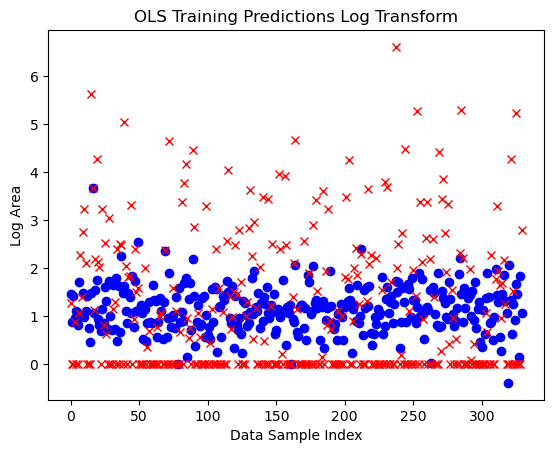

Training MSE: 1.7974549413600216
Training RMSE: 1.3406919636366967
Training SSE: 593.1601306488071


In [237]:
ols = OrdinaryLeastSquares()
ols.fit(X_trn, y_trn)

ols_y_hat_trn = ols.predict(X_trn)

_, ols_trn_sse, ols_trn_mse, ols_trn_rmse = analyze(ols_y_hat_trn, y_trn,
                                                    title="OLS Training Predictions Log Transform",
                                                    dataset="Training",
                                                    xlabel="Data Sample Index",
                                                    ylabel="Log Area")

With the added data we can see we got slightly lower scores than before. Recall our prior training MSE was around ~1.79 and our training RMSE was around ~1.34.

Now, let's see how we do on the test set!

#### TODO 14
Complete the TODO by feeding the testing set to the linear model.

1. Feed testing features `X_tst` to the `ols.predict()` for prediction.. Store the output into `ols_y_tst_hat`.
2. Feed the predicted results `ols_y_tst_hat` and true label `y_tst`, as two arguments, to the function of  `analyze`. 

There is no todo checker here.

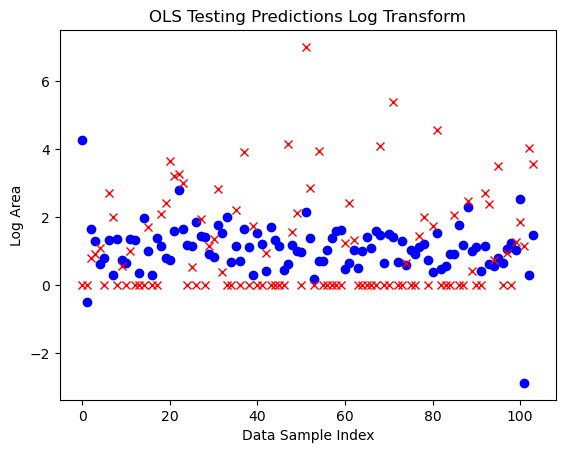

Testing MSE: 2.4720956020752807
Testing RMSE: 1.5722899230343241
Testing SSE: 257.0979426158292


In [240]:
#TODO 14.1
ols_y_tst_hat = ols.predict(X_tst)

_, ols_tst_sse, ols_tst_mse, ols_tst_rmse = analyze(
                                                    # TODO 14.2 (write down your code in the following line) 
                                                    ols_y_tst_hat, 
                                                    y_tst,
                                                    title="OLS Testing Predictions Log Transform",
                                                    dataset="Testing",
                                                    xlabel="Data Sample Index",
                                                    ylabel="Log Area")


Not too bad, these test scores are actually lower than our validation scores we originally had for OLS. Recall, our original validation MSE was about ~5.57 and the RMSE was about ~2.36. 